# Exact cover 3 solved with simulated annealing and quantum annealing

This notebook generates instances of the exact cover 3 (EC3) problem
and solves them with simulated annealing (anneal with thermal fluctuations) and quantum annealing (anneal with quantum fluctuations).

## Imports

In [1]:
import numpy as np, matplotlib.pyplot as plt, os, math
from scipy.sparse.linalg import expm, expm_multiply
from scipy.integrate import solve_ivp
from numba import njit
from tqdm.auto import tqdm, trange

In [2]:
def set_report():
    # figsize
    hor = 0.8; sc = 1  # 0.5
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.size': 25,
        #'font.weight': "bold",  # bold fonts
        #'lines.linewidth': 1,  # thick lines
        'grid.color': "0.5",  # gray gridlines
        'grid.linewidth': 0.5,  # thin gridlines
        'savefig.pad_inches': 0,
        'savefig.dpi': 300,  # higher resolution output.
        'figure.dpi': 200,
        'figure.figsize': [sc * 11.69, sc * 8.27 * hor],
    })

set_report()

# Miner

This class creates objects for different number of spins with methods for EC3 clauses generation, simulated annealing via Monte Carlo, and quantum annealing via a highly performant time evolution.

In [16]:
# Modified from https://github.com/b-irsigler/ML_MC
class Miner:
    def __init__(self, num_spins, folder_path):
        "Construct an object with num_spins of desired spins."
        self.num_spins = num_spins
        self.hil_dim = 2**num_spins
        self.folder_path = folder_path
        # diag = np.empty(self.hil_dim)
        # diag[:] = np.nan
        # self.hamiltonian_diag = diag
        self.hamiltonian_diag = np.empty(self.hil_dim, dtype=np.uint16)

        # Initialize common objects that only depend on num_spins
        assert num_spins <= 17, 'Too heavy computations for more than 17 spins, choose 17 or lower'
        # self.trans_field = self.field_term() # made negative in the H*psi multiplication

        # compute the initial state for the quantum annealing
        # GS for positive sum hamiltonian/norm
        # self.init_qstate = np.linalg.eigh(self.trans_field.astype(complex))[1][:, 0]
        # GS for negative sum hamiltonian/norm
        # self.init_qstate = np.linalg.eigh(self.trans_field.astype(complex))[1][:, -1]
        self.init_qstate = np.ones(self.hil_dim, dtype=complex)/np.sqrt(self.hil_dim, dtype=complex)

        # get indices of nonzero terms of the field term for their contribution in the quantum annealing
        # self.trans_field_i = np.nonzero(self.trans_field)[1]
        # load precomputed indices
        try:
          self.trans_field_i = np.load('field_term_i' '.npy').reshape(-1,17)[:self.hil_dim,:num_spins]
        except FileNotFoundError:
          print('Creating field term...')
          np.save('field_term_i', np.nonzero(hypercube_adjacency(17))[1])
          self.trans_field_i = np.load('field_term_i' '.npy').reshape(-1,17)[:self.hil_dim,:num_spins]
          print('Done.')

    # EC3 ########################
    def random_clauses(self, num_clauses):
        "Sample num_clauses random clauses."
        self.num_clauses = num_clauses
        # # np.uint8: unsigned int with 2**8 possible values:[0,255], a byte
        # clauses = np.empty((self.num_clauses, 3), dtype=np.uint8)
        # spin_idx = np.arange(self.num_spins, dtype=np.uint8)
        # for i in range(self.num_clauses):
        #     # Sample three spin indices.
        #     clauses[i] = np.random.choice(spin_idx, 3, replace=False)
        # self.clauses = clauses
        # # are all these clauses different?? 
        # it is possible and indeed probable that there are repetitions
        # # subsaned with:
        self.clauses = make_set_random_clauses(1, self.num_spins,num_clauses)[0]

    def get_clauses(self, num_clauses, idx_clauses):
        "Loads num_clauses clauses."
        self.clauses = np.load(f'EC3_N{self.num_spins}M{num_clauses}clauses.npz')['clauses'][idx_clauses]
    def get_rclauses(self, num_clauses, idx_clauses):
        "Loads num_clauses clauses by the index."
        self.clauses = np.load(self.folder_path + f'EC3_N{self.num_spins}M{num_clauses}clauses_r.npz')['clauses'][idx_clauses]

    # Simulated annealing via Monte Carlo Metropolis-Hastings ##############
    def initial_state(self):
        "Samples a new State containing (1, -1) spin orientations."
        self.state = (-1)**np.random.randint(0, 2, size=self.num_spins, dtype=np.int8)
        self.state_energy = classic_energy_for(self.state, self.clauses)
        return self.state

    def classic_energy(self, state):
        "Construct a classical Hamiltonian entry from given state and clauses."
        return ((state[self.clauses].sum(1) -1)**2).sum()
        # # vectorial form above, for loop below
        # energy = 0
        # for i in range(self.num_clauses):
        #     energy = energy + (state[self.clauses[i]].sum() - 1)**2
        # return energy

    def fill_hamiltonian(self):
        "Fills the hamiltonian diagonal computing all the classical energies possible 2**N_spins."
        self.hamiltonian_diag = np.stack([classic_energy_for(self.bin_decode(i),self.clauses) for i in range(self.hil_dim)])[::-1]
        # for i in range(self.hil_dim):
        #     self.hamiltonian_diag[i] = self.classic_energy(self.bin_decode(i))
        # self.hamiltonian_diag = self.hamiltonian_diag[::-1]

    def flip_spin_proposal(self, ind_spin):
        "Propose energy and state of a single spin flip."
        proposed_state = self.state.copy()
        proposed_state[ind_spin] = -proposed_state[ind_spin]
        # return self.classic_energy(proposed_state), proposed_state
        # #slower #return self.hamiltonian_diag[self.hil_dim-1-self.bin_encode(proposed_state)], proposed_state
        # njitted version faster than vectorized
        return classic_energy_for(proposed_state, self.clauses), proposed_state

    def mc_step(self, rand_spin, temperature):
        "Perform single MC step."
        proposal_energy, proposal_state = self.flip_spin_proposal(rand_spin)
        delta_energy = proposal_energy - self.state_energy
        if delta_energy < 0:  # accept the change
            self.state[rand_spin] = -self.state[rand_spin]
            self.state_energy = proposal_energy
        else:
            # p = np.random.rand()
            # bltzmnn = np.exp(-delta_energy / temperature) if temperature > 0 else 0
            # if p < bltzmnn:
            # using njitted boltzmann function
            if boltzmann(delta_energy, temperature):  # accept the change
                self.state[rand_spin] = -self.state[rand_spin]
                self.state_energy = proposal_energy

        # self.hamiltonian_diag[self.hil_dim - 1 -
        #     self.binary_encode(proposal_state)] = proposal_energy
        # why the hamiltonian is changing? filling it while sampling?
        # yes, inherited from missing data idea.

    def mc_loop(self, num_steps, rand_spins, temperatures):
        "Loop over MC steps."
        assert len(temperatures) == num_steps
        energies = np.empty(num_steps, dtype=np.uint16)
        states   = np.empty((num_steps, self.num_spins),dtype=np.int8)
        for i in range(num_steps):
            self.mc_step(rand_spins[i], temperatures[i])
            energies[i] = self.state_energy
            states[i]   = self.state
        return energies, states

    def bin_encode(self, state):
        "Representation of the state as an integer."
        zero_one_rep = (1 - state[::-1]) / 2
        two_basis = 2**np.arange(self.num_spins, dtype=np.uint16)
        return np.sum(zero_one_rep * two_basis, dtype=np.uint16)

    def bin_decode(self, bin_rep):
        "Find spin representation from binary decoding."
        return (-1)**np.array(list(bin(bin_rep)[2:].zfill(self.num_spins)),dtype=np.int8)

    # Quantum annealer part ####################################
    # H = H_q -> H_problem: h 0->1
    def field_term_(self):
        sigma_0 = np.identity(2)
        sigma_x = np.array([[0, 1], [1, 0]])
        term = np.zeros((self.hil_dim, self.hil_dim))
        for i in range(self.num_spins):
            A = sigma_x if i==0 else sigma_0
            for j in range(1, self.num_spins):
                if i == j and i > 0:
                    A = np.tensordot(A, sigma_x, axes=0).swapaxes(1, 2)\
                        .reshape((2*A.shape[0], 2*A.shape[0]))
                else:
                    A = np.tensordot(A, sigma_0, axes=0).swapaxes(1, 2)\
                        .reshape((2*A.shape[0], 2*A.shape[0]))
            term += A
        return term

    def field_term(self): return hypercube_adjacency(self.num_spins)

    def time_evolution(self, T, num_times, full_exp=True, ivp=False):
        I = np.identity(self.hil_dim)

        times = np.linspace(0, T, num_times)
        self.times = times
        delta_t = T / num_times

        fid_t = np.zeros((num_times, ))

        H_q = self.field_term().astype(complex)  # Field
        H_p = np.diag(self.hamiltonian_diag).astype(complex)  # Energies

        assert abs(H_p - H_p.T.conj()).max() < 1e-15
        assert abs(H_q - H_q.T.conj()).max() < 1e-15

        # eigenvalues and eigenvectors
        self.final_qstate = np.linalg.eigh(H_p)[1][:, 0]
        self.final_qstate_idx = np.where(H_p == H_p.min())[0]
        self.qstate = self.init_qstate.copy()
        y = np.zeros((2**self.num_spins,num_times),dtype=complex)
        for i, t in enumerate(times):
            h = t / T
            # H = h * H_p + (1-h) * H_q
            H = h * H_p + (h-1) * H_q  # to use negative H_q GS
            if full_exp:
                # U = expm(-1j * delta_t * H)  # <-- the most expensive line
                # self.qstate = np.dot(U, self.qstate)
                self.qstate = expm_multiply(-1j * delta_t * H, self.qstate) # 20x faster
            elif ivp:
                t_span = (times[i-1], t) if i>0 else (0., t)
                sol = solve_ivp(Hpsi, t_span, self.qstate, method='RK45',
                                # t_eval=None, dense_output=False, events=None, vectorized=False,
                                args=(H_q,H_p,T))
                self.qstate = sol.y[:,-1] #  2**N, t_evaluations
            else:
                # faster approx. used with bigger number of anneal_steps.
                U = I - 1j * delta_t * H - delta_t**2 / 2. * np.dot(H, H)
                self.qstate = np.dot(U, self.qstate)
            y[:,i] = self.qstate
            fid_t[i] = self.fidelity()

        # take into account degeneracy for fidelity
        # fid_t = fidelity_degenerate(self.final_qstate_idx, y)
        self.sol = y
        return fid_t

    def time_evolution_ivp(self, T,
                           num_times=None, # specify number of steps or leave it to the solver (default)
                           atol=1e-7, rtol=1e-6,
                           method='DOP853', # 'DOP853' or 'RK45'
                          ):
        times = np.linspace(0, T, num_times) if num_times is not None else None
        fid_t = np.zeros((num_times, )) if num_times is not None else np.zeros((0, ))

        H_q = self.field_term().astype(complex)  # Field
        H_p = np.diag(self.hamiltonian_diag).astype(complex)  # Energies

        # Hermitian
        assert abs(H_q - H_q.T.conj()).max() < 1e-15
        assert abs(H_p - H_p.T.conj()).max() < 1e-15

        # eigenvalues[0][i] and eigenvectors[1][:,i]
        self.final_qstate = np.linalg.eigh(H_p)[1][:, 0]
        self.final_qstate_idx = np.where(H_p == H_p.min())[0]

        self.qstate_ = self.init_qstate.copy()

        t_span = (0., T)
        self.sol = solve_ivp(Hpsi, t_span, self.qstate_,
                        method=method, t_eval=times,
                        args=(H_q,H_p,T),
                        atol=atol,rtol=rtol,)
        self.qstate_ = self.sol.y[:,-1]
        fid_t = fidelity_(self.final_qstate, self.sol.y)
        #fid_t = fidelity_degenerate(self.final_qstate_idx, self.sol.y)
        return fid_t

    def time_evolution_ivp2(self, T,
                            num_times=None, # specify number of steps or leave it to the solver
                            atol=1e-7, rtol=1e-6,
                            method='DOP853', # or 'RK45',
                           ):
        times = np.linspace(0, T, num_times) if num_times is not None else None
        fid_t = np.zeros((num_times, )) if num_times is not None else np.zeros((0, ))

        H_p = self.hamiltonian_diag
      
        self.final_qstate = np.linalg.eigh(np.diag(H_p).astype(complex))[1][:, 0]
        self.final_qstate_idx = np.where(H_p == H_p.min())[0] #hpmin should take into account that is diagonal??

        H_q_i = self.trans_field_i

        t_span = (0., T)
        self.sol = solve_ivp(Hpsi_, t_span, self.init_qstate,
                        method=method,t_eval=times,
                        args=(H_q_i,H_p,T, self.num_spins),
                        atol=atol, rtol=rtol,)
        self.qstate_ = self.sol.y[:,-1]
      
        fid_t = fidelity_(self.final_qstate, self.sol.y)

        fid_t = fidelity_degenerate(self.final_qstate_idx, self.sol.y)

        return fid_t

    def fidelity(self):
        return abs(np.sum(self.final_qstate.T.conj() * self.qstate))

    def sample_ratio(self):
        return (self.hil_dim -
                np.isnan(self.hamiltonian_diag).sum()) / self.hil_dim

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def fidelity_(final_qstate, qstate, # shape (2**N)
             ):
    "Fidelity for solve_ivp, in a vectorized fashion"
    return abs(np.dot(final_qstate.T.conj(),qstate))

def fidelity_degenerate(final_qstates_idx, qstates, # shape (2**N,num_timesteps)
                       ):
    """Fidelity between an arbitrary state and possibly degenerate ground states"""
    return np.sum(np.power(np.abs(qstates[final_qstates_idx]),2), axis=0)
    # return np.max(np.abs(qstates[final_qstates_idx]), axis=0)

def Hpsi(t,psi, H_q, H_p,T):
    """RHS of the time dependent Schrödinger equation:
    \delta |psi> = -i H |psi>
    """
    #   returns array_RHS # [n] or [n,k] for vectorized True
    h = t / T # h: 0->1
    # H = h * H_p + (1.-h) * H_q
    H = h * H_p + (h-1) * H_q  # to use negative H_q GS
    return -1j*np.dot(H, psi)

def Hpsi_(t: float, psi: complex,
          H_q, H_p,
          T:float, N:int=7):
    """Highly performant and verbose implementation of the
    RHS of the time dependent Schrödinger equation:
        \delta |psi> = -i H |psi>,
    for an annealing Hamiltonian
        H = (1-h) H_q + h H_p.
    H_q, H_p = initial field_term, final energy diagonal
    """
    h = t / T  # h: 0->1
    h_1 = h-1.
        # h-1. for negative sum H_q hamiltonian
        # 1.-h for positive sum hamiltonian
    H_p =  h * H_p
    psi_p = H_p * psi
    # Intead of :
    # psi_q = H_q * psi
    # since H_q is a sparse matrix of ones
    # we only need to do a masked sum
    # mask = np.nonzero(H_q)
    # psi_q = np.sum(psi[mask[1]].reshape(-1,7), axis=-1)
    psi_q = np.sum(psi[H_q].reshape(-1,N), axis=-1)
    # and then multiply by the scalar (1-h)
    psi_q = h_1 * psi_q
    psi_evo = psi_q + psi_p
    RHS = -1j * psi_evo
    return RHS

def hypercube_adjacency(N):
    if N == 1:
        return np.asarray([[0, 1], [1, 0]], dtype=np.uint8)
    A = np.zeros((2**N, 2**N), dtype=np.uint8)
    A_ = hypercube_adjacency(N - 1) # recursion
    twoN_ = 2**(N-1)
    I = np.eye(twoN_, dtype=np.uint8)
    A[:twoN_][:, :twoN_] = A_
    A[twoN_:][:, twoN_:] = A_
    A[twoN_:][:, :twoN_] = I
    A[:twoN_][:, twoN_:] = I
    return A

def sample_set_clauses(N,M): return np.random.rand(M,N).argpartition(3,axis=1)[:,:3]
# from https://stackoverflow.com/a/47676734 thanks to Divakar

def ec3_num_combinations(N,M): return math.comb(math.comb(N,3),M)

def make_set_random_clauses(num_samples, N,M):
    assert ec3_num_combinations(N,M) > num_samples, f'There are {ec3_num_combinations(N,M)} combinations but you asked for {num_samples}.'
    result = set()
    while(len(result) < num_samples):
        # sample one set of clauses
        set_clauses = sample_set_clauses(N,M)
        # sort to have a canonical expression that is hashed
        # to avoid the case of repeated clause with different order
        set_clauses.sort()
        # convert each row in the np.array to a tuple, so it is hashable.
        # https://stackoverflow.com/questions/51801593/create-a-set-of-numpy-arrays
        # To represent sets of sets, the inner sets must be frozenset objects.
        # https://docs.python.org/3/library/stdtypes.html#frozenset
        rand = frozenset({tuple(row) for row in set_clauses})
        # filter non M-unique set of clauses
        if len(rand)==M: result.add(rand)
    result = np.array([list(fs) for fs in result], dtype=np.uint8)
    return result

@njit
def classic_energy_for(state,   # shape (2**N)
                       clauses, # shape (M, 3)
                      ):
    energy = 0
    for i in range(len(clauses)):
        spin_sum = 0
        for spin in state[clauses[i]]:
            spin_sum = spin_sum + spin
        energy = energy + (spin_sum-1)**2
    return energy

@njit
def boltzmann(delta_energy, temperature):
    if temperature > 0:
        bltzmnn = np.exp(-delta_energy / temperature)
        p = np.random.rand()
        return p < bltzmnn
    else:
        return False

In [17]:
# states
num_spins = 7
num_clauses = 5
num_mc_steps = 100
start_temperature = 10
num_repetitions = 5
anneal_T = 10
anneal_steps = 100#500

folder_path = 'data/raw/mc_clauses_with_degenerate_GS/'
miner = Miner(num_spins,folder_path)
# generate a set of random clauses
miner.random_clauses(num_clauses)

# Monte Carlo part:
# Metropolis Monte Carlo  with Simulated Annealing (anneal with thermal fluctuations)
initial_state = miner.initial_state()
mc_time_energies = np.zeros((num_mc_steps, num_repetitions))
mc_time_states = np.zeros((num_mc_steps, num_spins, num_repetitions))
# temperatures schedule => Annealing
temperatures = np.linspace(start_temperature, 0, num_mc_steps)
# generate all random ints at once
rand_spins = np.random.randint(0, num_spins, size=(num_repetitions,num_mc_steps), dtype=np.uint8)
# Loop over different random initial states for the same instance
for i in range(num_repetitions):
    miner.state = initial_state  # miner.initial_state() # get another initial state
    time_line_energies, time_line_states = miner.mc_loop(
        num_mc_steps,rand_spins[i], temperatures)  # energies
    mc_time_energies[:, i] = time_line_energies
    mc_time_states[..., i] = time_line_states

# Quantum Annealing (anneal with quantum fluctuations)
miner.fill_hamiltonian() # needed before time evolution

In [18]:
fid_time = miner.time_evolution(
    anneal_T, anneal_steps, full_exp=True
)
sol_y = miner.sol
fid_timeivp = miner.time_evolution_ivp(
    anneal_T, anneal_steps)
sol_y1 = miner.sol.y
fid_timeivp2 = miner.time_evolution_ivp2(
    anneal_T,anneal_steps)
sol_y2 = miner.sol.y

In [19]:
np.allclose(sol_y,sol_y1)

False

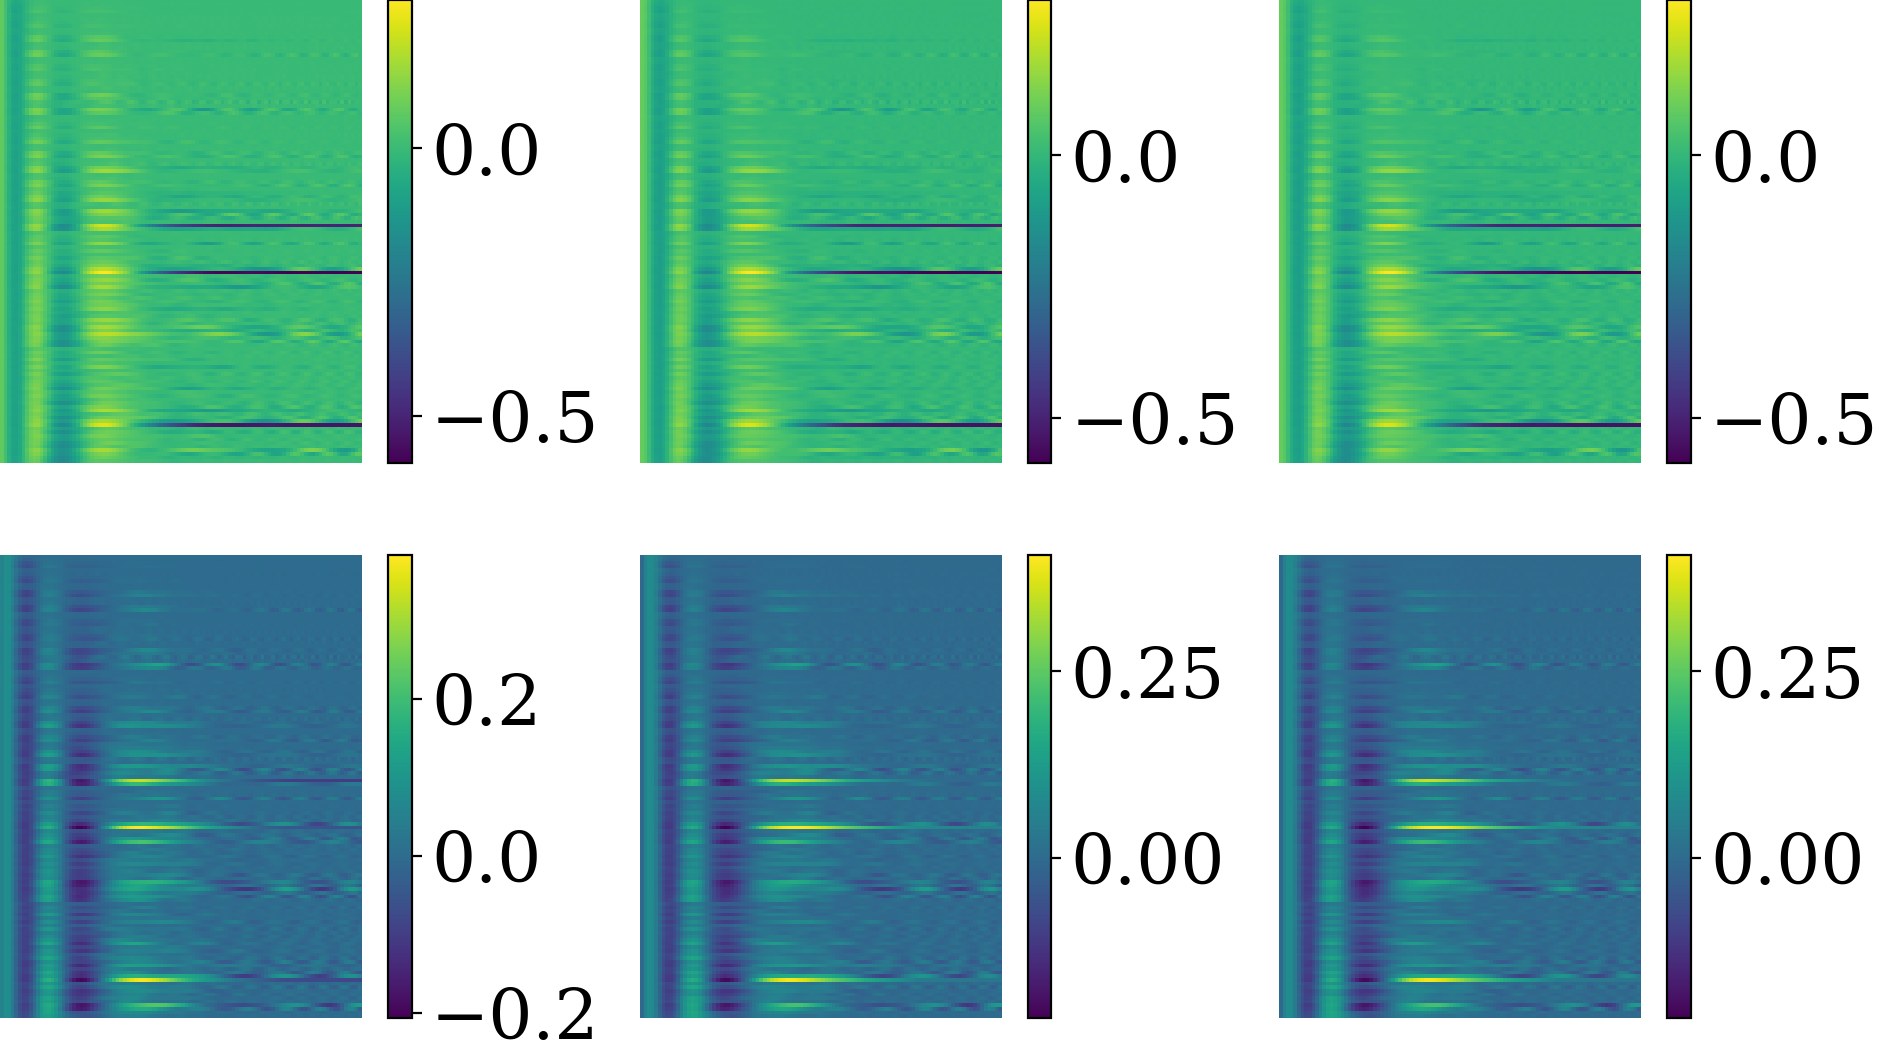

In [21]:
for i,s in enumerate([sol_y, sol_y1, sol_y2]):
  plt.subplot(2,3,i+1); plt.imshow(s.real); plt.axis('off');  plt.colorbar()
  plt.subplot(2,3,i+1+3); plt.imshow(s.imag); plt.axis('off');  plt.colorbar()

In [22]:
miner.state, miner.clauses

(array([-1,  1,  1,  1,  1,  1, -1], dtype=int8),
 array([[0, 1, 5],
        [2, 3, 6],
        [0, 1, 3],
        [0, 2, 5],
        [0, 4, 5]], dtype=uint8))

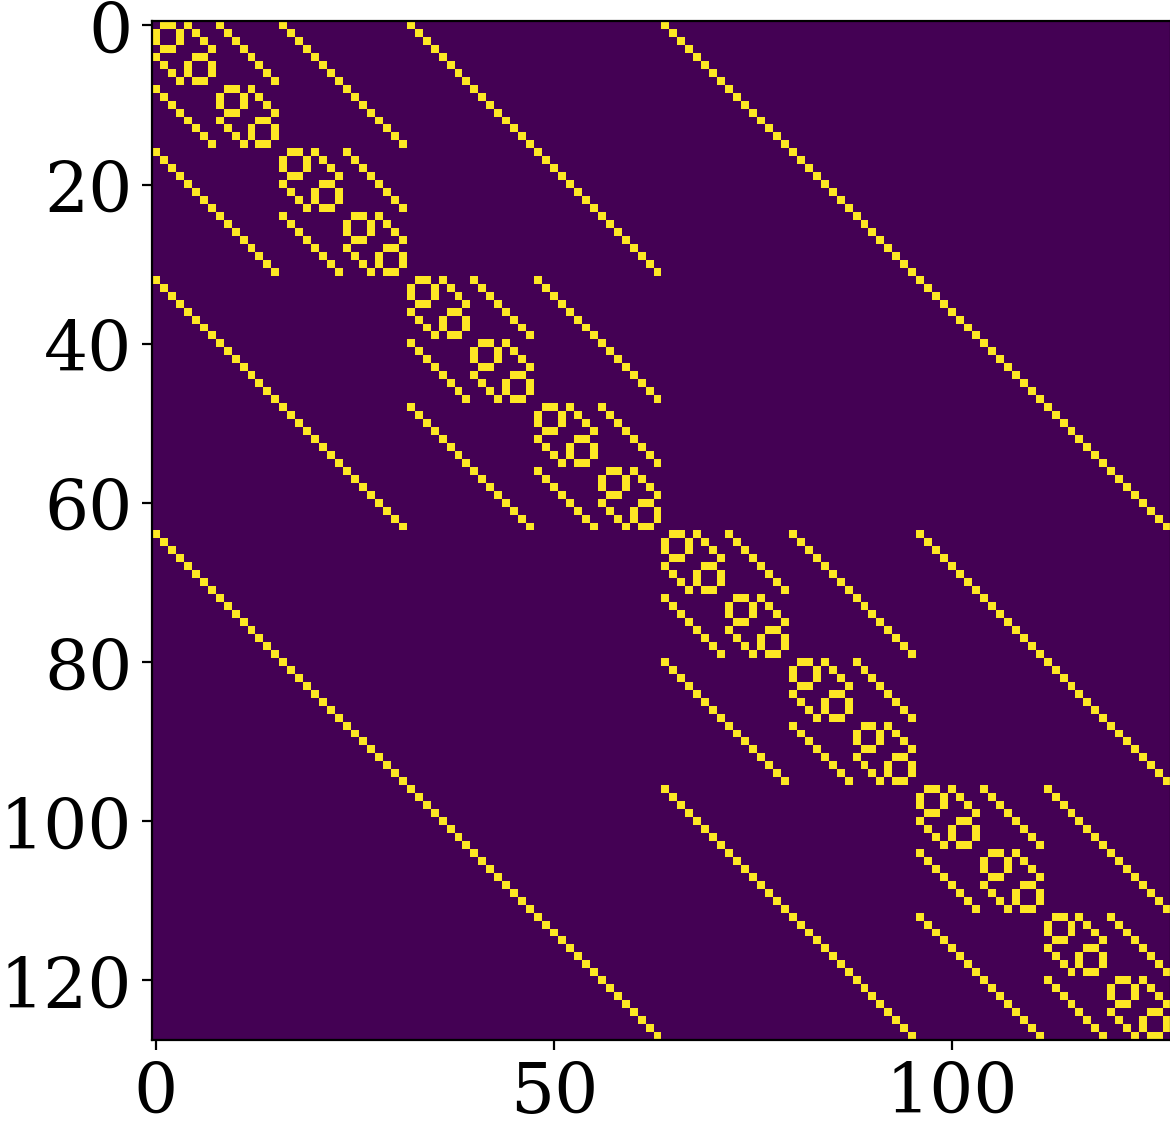

In [23]:
plt.imshow(miner.field_term()); # Field

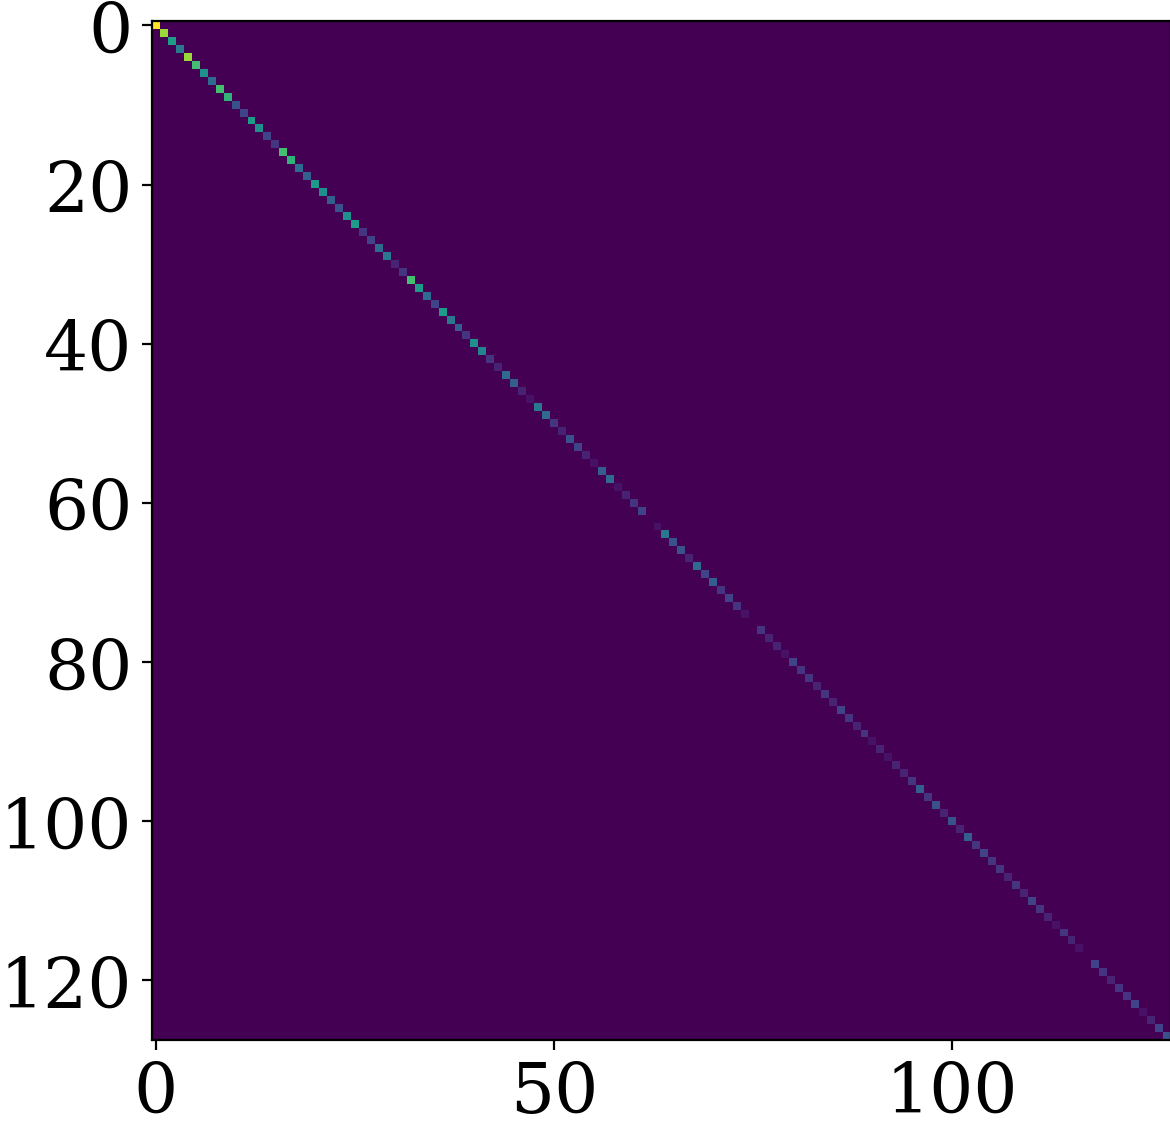

In [24]:
plt.imshow(np.diag(miner.hamiltonian_diag));

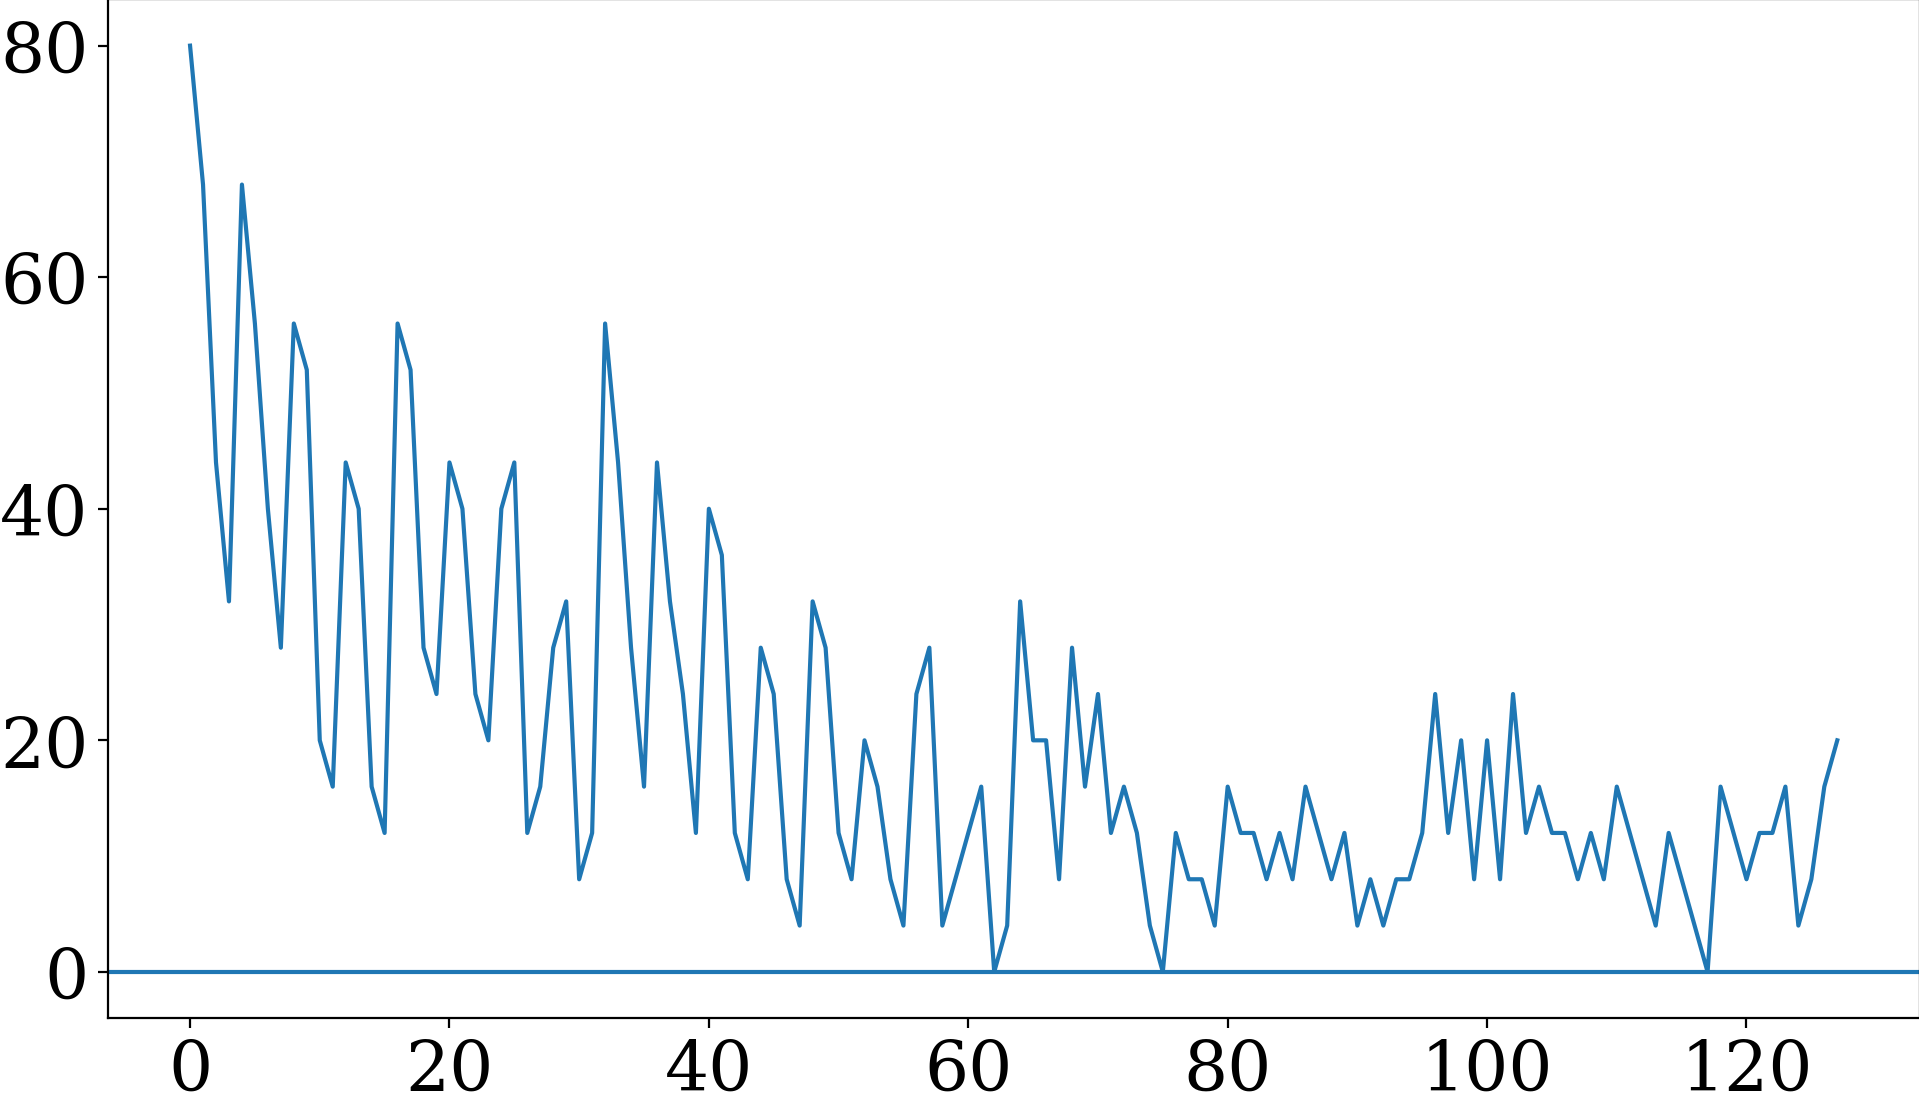

In [31]:
plt.plot(miner.hamiltonian_diag); plt.axhline(0);

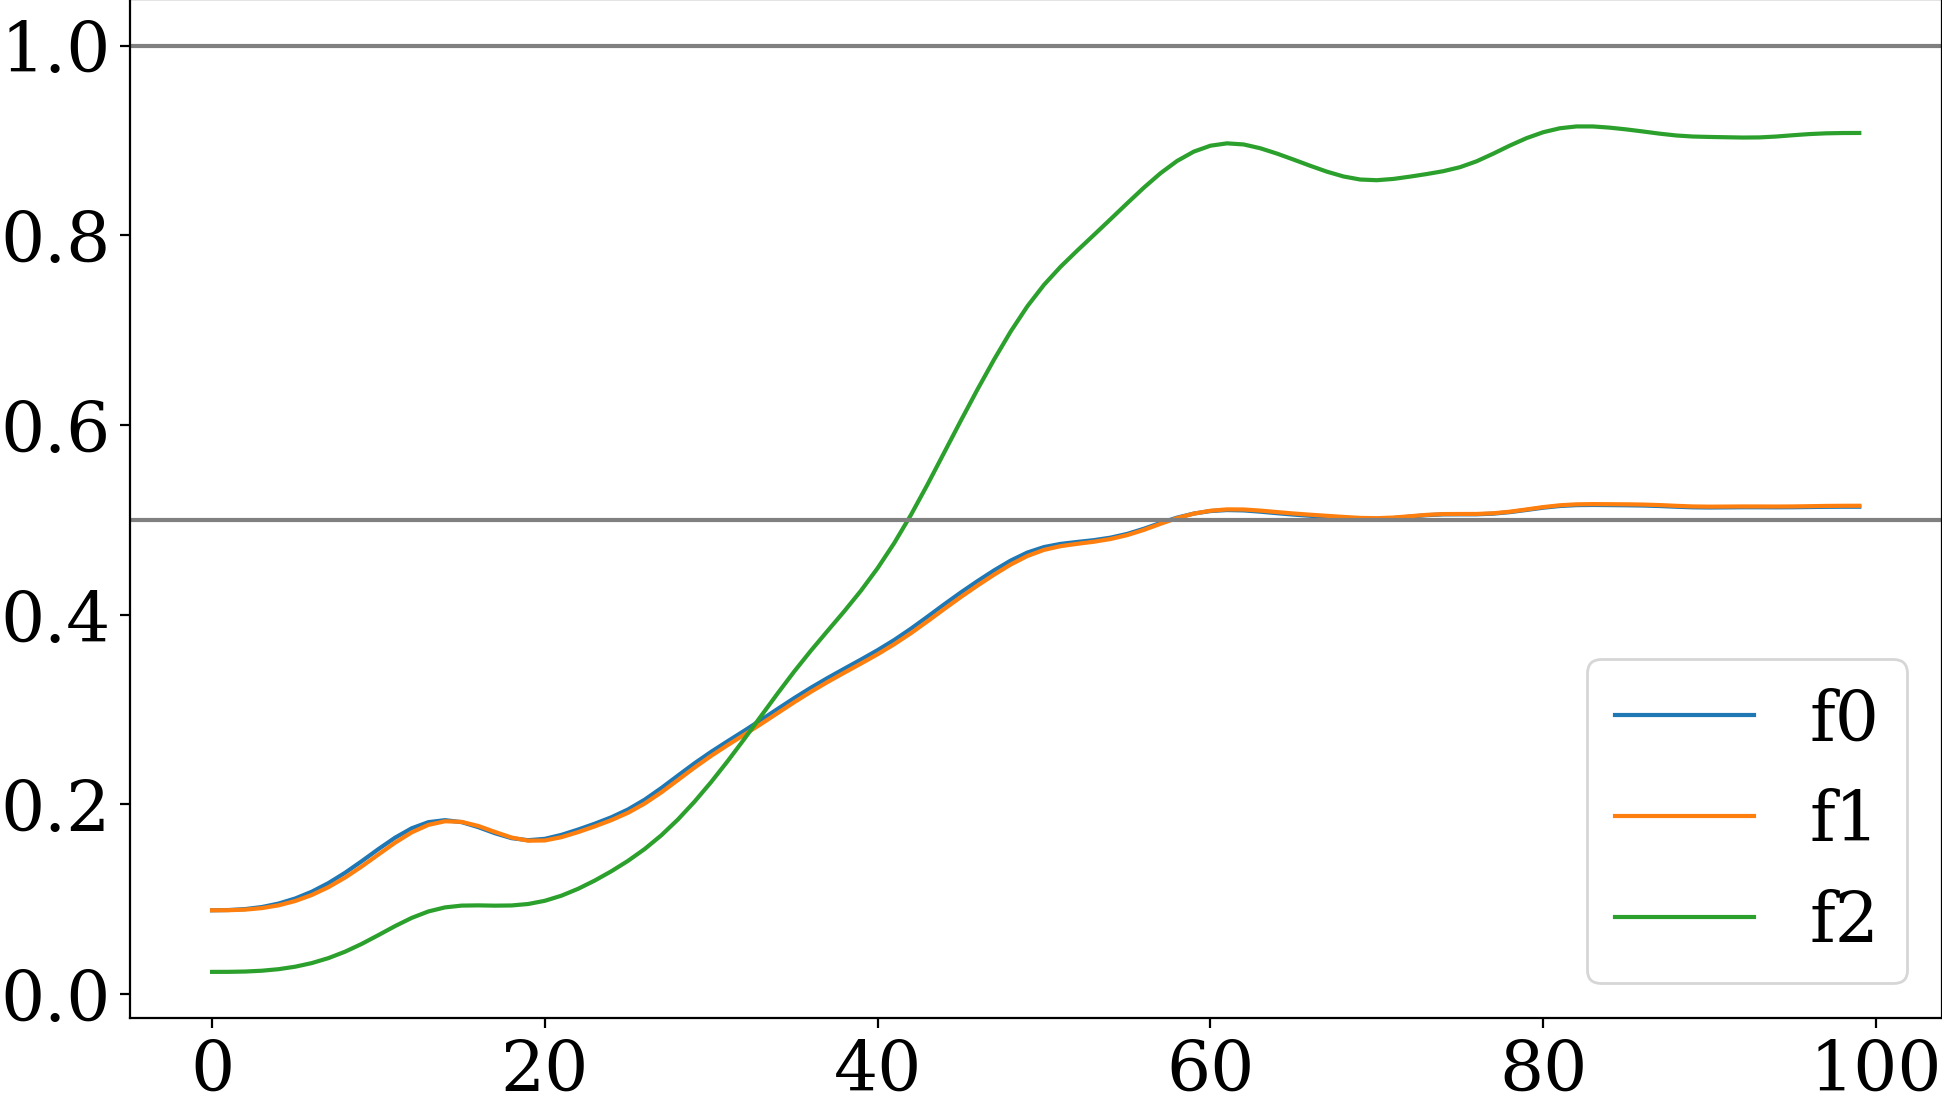

In [30]:
for i,x in enumerate([fid_time, fid_timeivp, fid_timeivp2]):
  plt.plot(x, label=f'f{i}');
plt.legend();plt.axhline(1, c='gray');plt.axhline(0.5, c='gray');

# EC3 Instance

In [32]:
def instance(miner, idx_instance, num_spins, num_clauses, rand_spins,
             num_mc_steps, start_temperature, num_repetitions, anneal_T,
             anneal_steps=None, MC=True):
    # miner.get_clauses(num_clauses, idx_instance)
    miner.get_rclauses(num_clauses, idx_instance)
    # Monte Carlo part:
    # Metropolis Monte Carlo  with Simulated Annealing (anneal with thermal fluctuations)
    # initial_state = miner.initial_state()
    mc_time_energies = np.empty((num_mc_steps, num_repetitions), dtype=np.uint16)
    mc_time_states   = np.empty((num_mc_steps, num_spins, num_repetitions), dtype=np.int8)
    # temperatures schedule => Annealing
    temperatures = np.linspace(start_temperature, 0, num_mc_steps)
    miner.fill_hamiltonian() # --> miner.hamiltonian_diag
    # Loop over different random initial states for the same instance # parallel
    if MC:
        for i in range(num_repetitions):
            miner.state = miner.initial_state() # get another initial state
            time_line_energies, time_line_states = miner.mc_loop(
                num_mc_steps, rand_spins[i], temperatures)  # energies
            mc_time_energies[:, i] = time_line_energies
            mc_time_states[..., i] = time_line_states

    # Quantum Annealing (anneal with quantum fluctuations)
    fid_time2 = miner.time_evolution_ivp2(anneal_T) # anneal_steps=None
    # sol_y2 = miner.sol.y
    # fid_time1 = miner.time_evolution_ivp(anneal_T)
    # sol_y1 = miner.sol.y
    # fid_time = miner.time_evolution(anneal_T, len(fid_time2), full_exp=True)
    # sol_y = miner.sol
    # return miner.clauses, miner.hamiltonian_diag, mc_time_energies, mc_time_states, fid_time, fid_time1, fid_time2, sol_y,sol_y1,sol_y2
    return miner.clauses, miner.hamiltonian_diag, mc_time_energies, mc_time_states, fid_time2

In [33]:
# Result of a single instance with 10 different repetitions of different random initial
# states
num_spins = 7
num_clauses = 5
# num_instances = 2
num_mc_steps = 100
start_temperature = 10
num_repetitions = 100 # for the same instance # 5
anneal_T = 10
anneal_steps = 50
folder_path = 'data/raw/mc_clauses_with_degenerate_GS/'
os.makedirs(folder_path,exist_ok=True)
idx_instance = 0

In [34]:
miner = Miner(num_spins, folder_path)

In [35]:
# make set of random clauses if they do not exist already and save them
clauses_name = f'EC3_N{num_spins}M{num_clauses}clauses_r.npz'

if not os.path.isfile(folder_path + clauses_name):
    clauses = np.empty((1,num_clauses,3,), dtype=np.uint8)
    miner.random_clauses(num_clauses)
    clauses[0] = miner.clauses
    np.savez_compressed(folder_path + clauses_name,clauses=clauses,)
rand_spins = np.random.randint(0, num_spins, size=(num_repetitions,num_mc_steps), dtype=np.uint8)

In [36]:
clauses, hamiltonian_diag, mc_time_energies, mc_time_states, *fidelity = instance(miner, idx_instance,
    num_spins, num_clauses, rand_spins, num_mc_steps, start_temperature, num_repetitions, anneal_T, anneal_steps)

In [37]:
clauses

array([[1, 5, 6],
       [2, 3, 4],
       [2, 3, 6],
       [0, 3, 4],
       [2, 3, 5]], dtype=uint8)

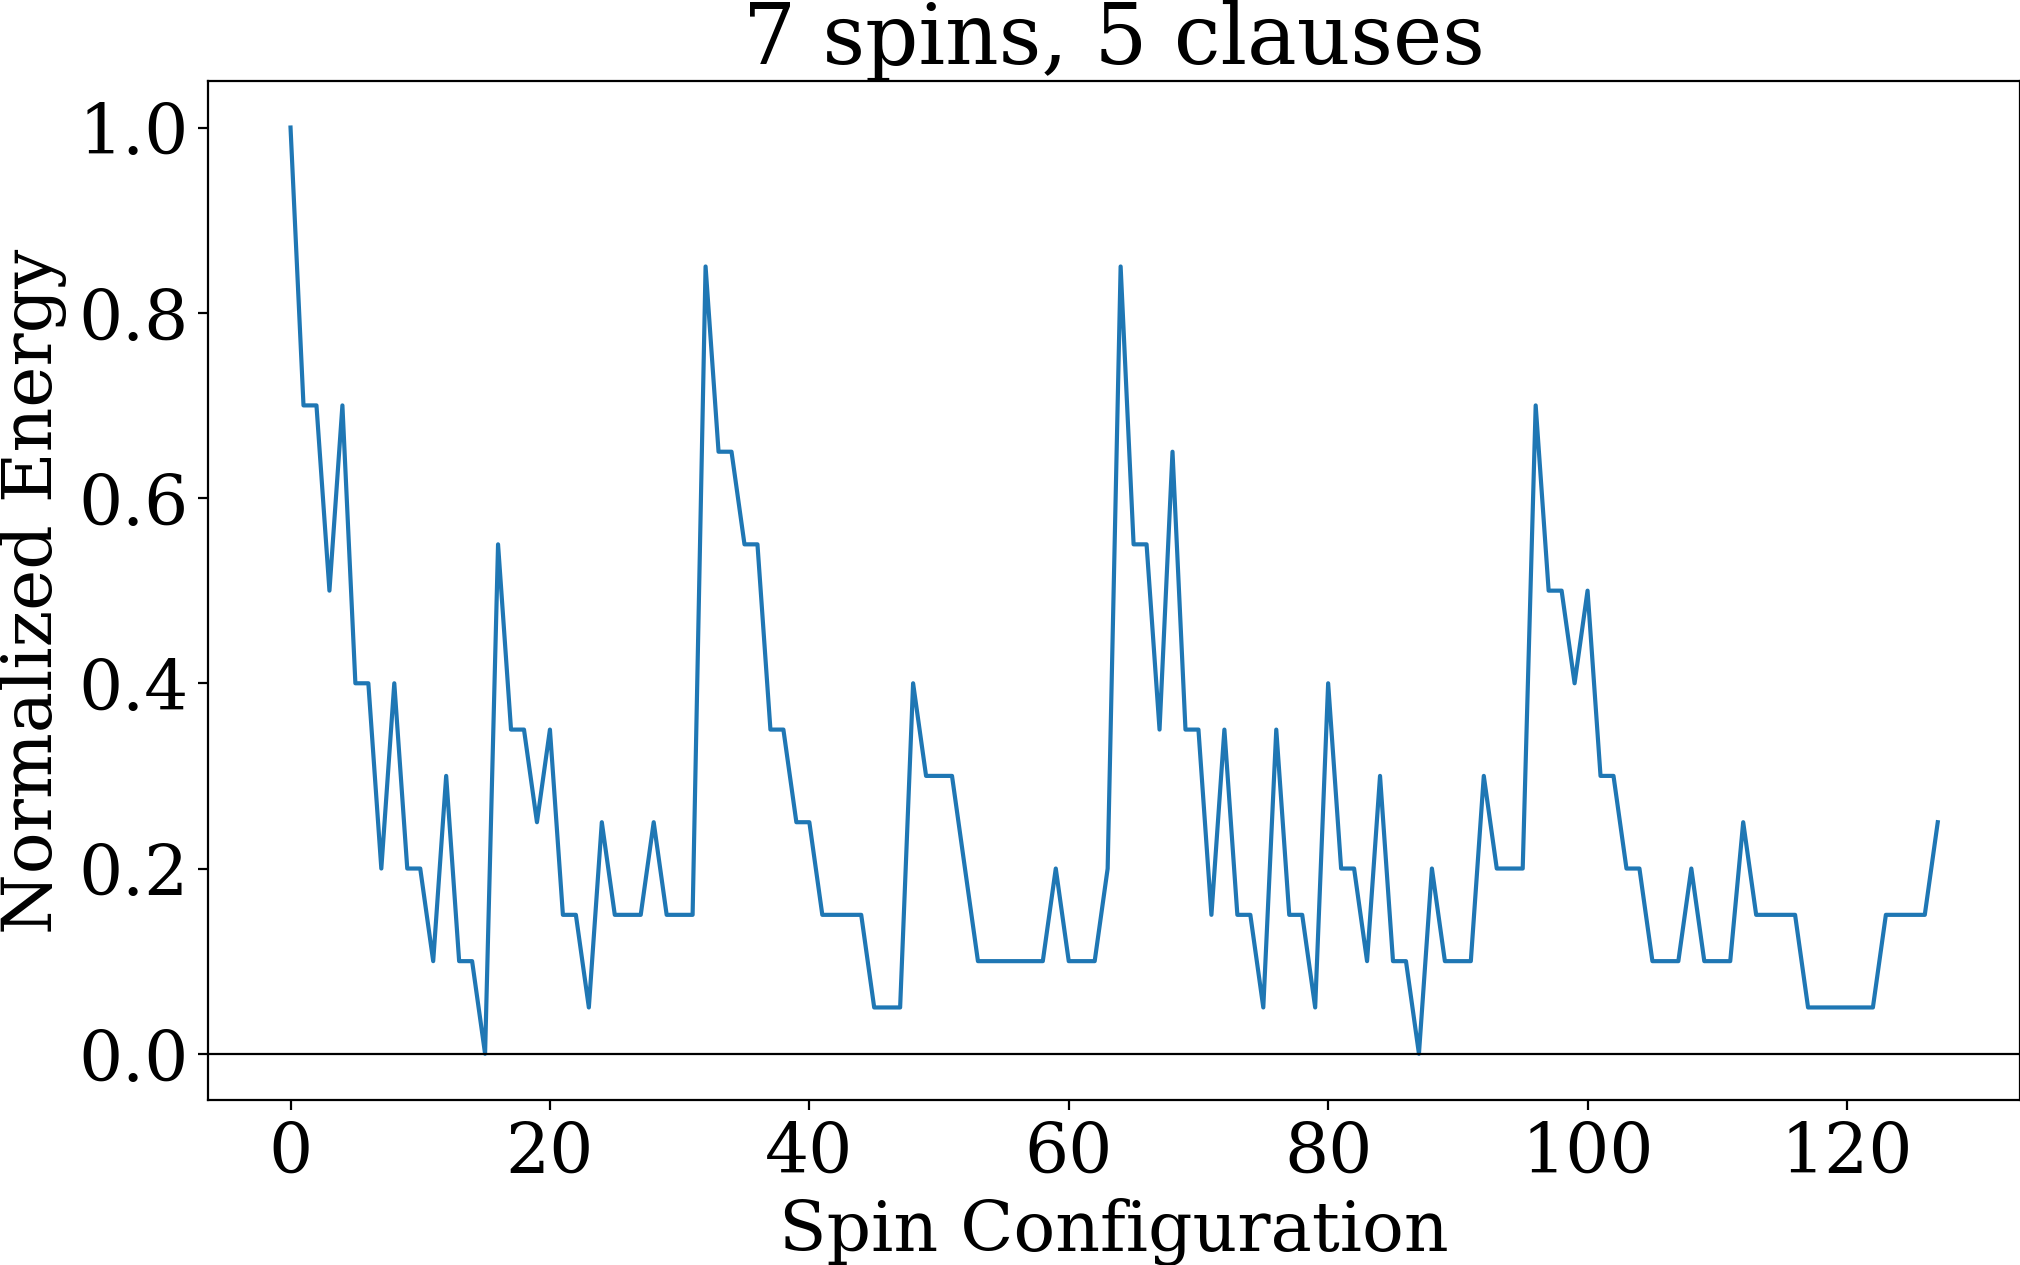

In [39]:
hamiltonian_diag_max = hamiltonian_diag.max()
plt.plot(hamiltonian_diag / hamiltonian_diag_max)
plt.axhline(0, c='k', lw=0.8)
plt.xlabel("Spin Configuration")
plt.ylabel("Normalized Energy")
title = f"{num_spins} spins, {num_clauses} clauses"
plt.title(title);

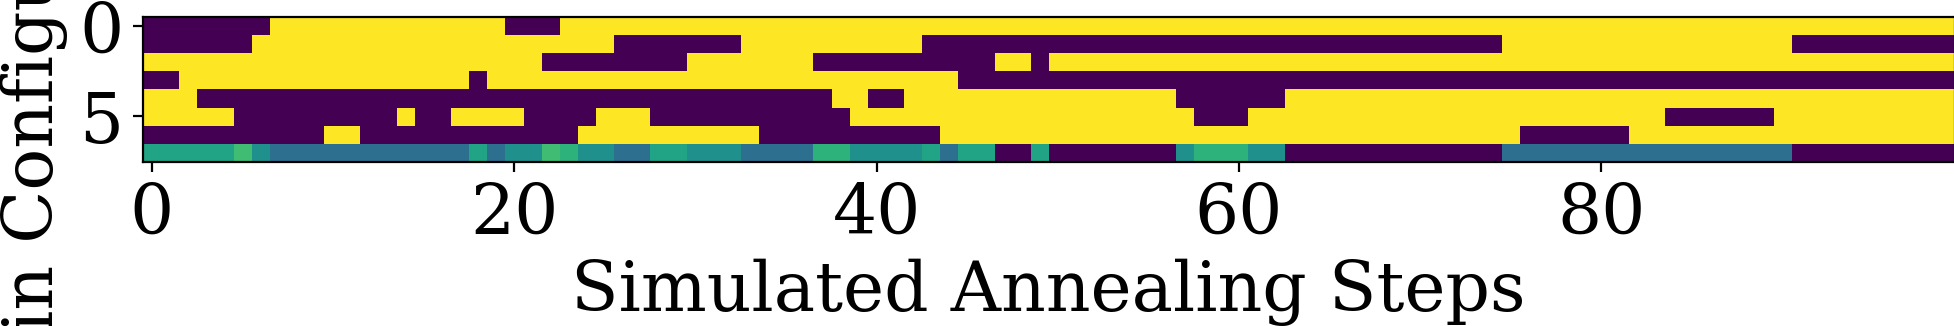

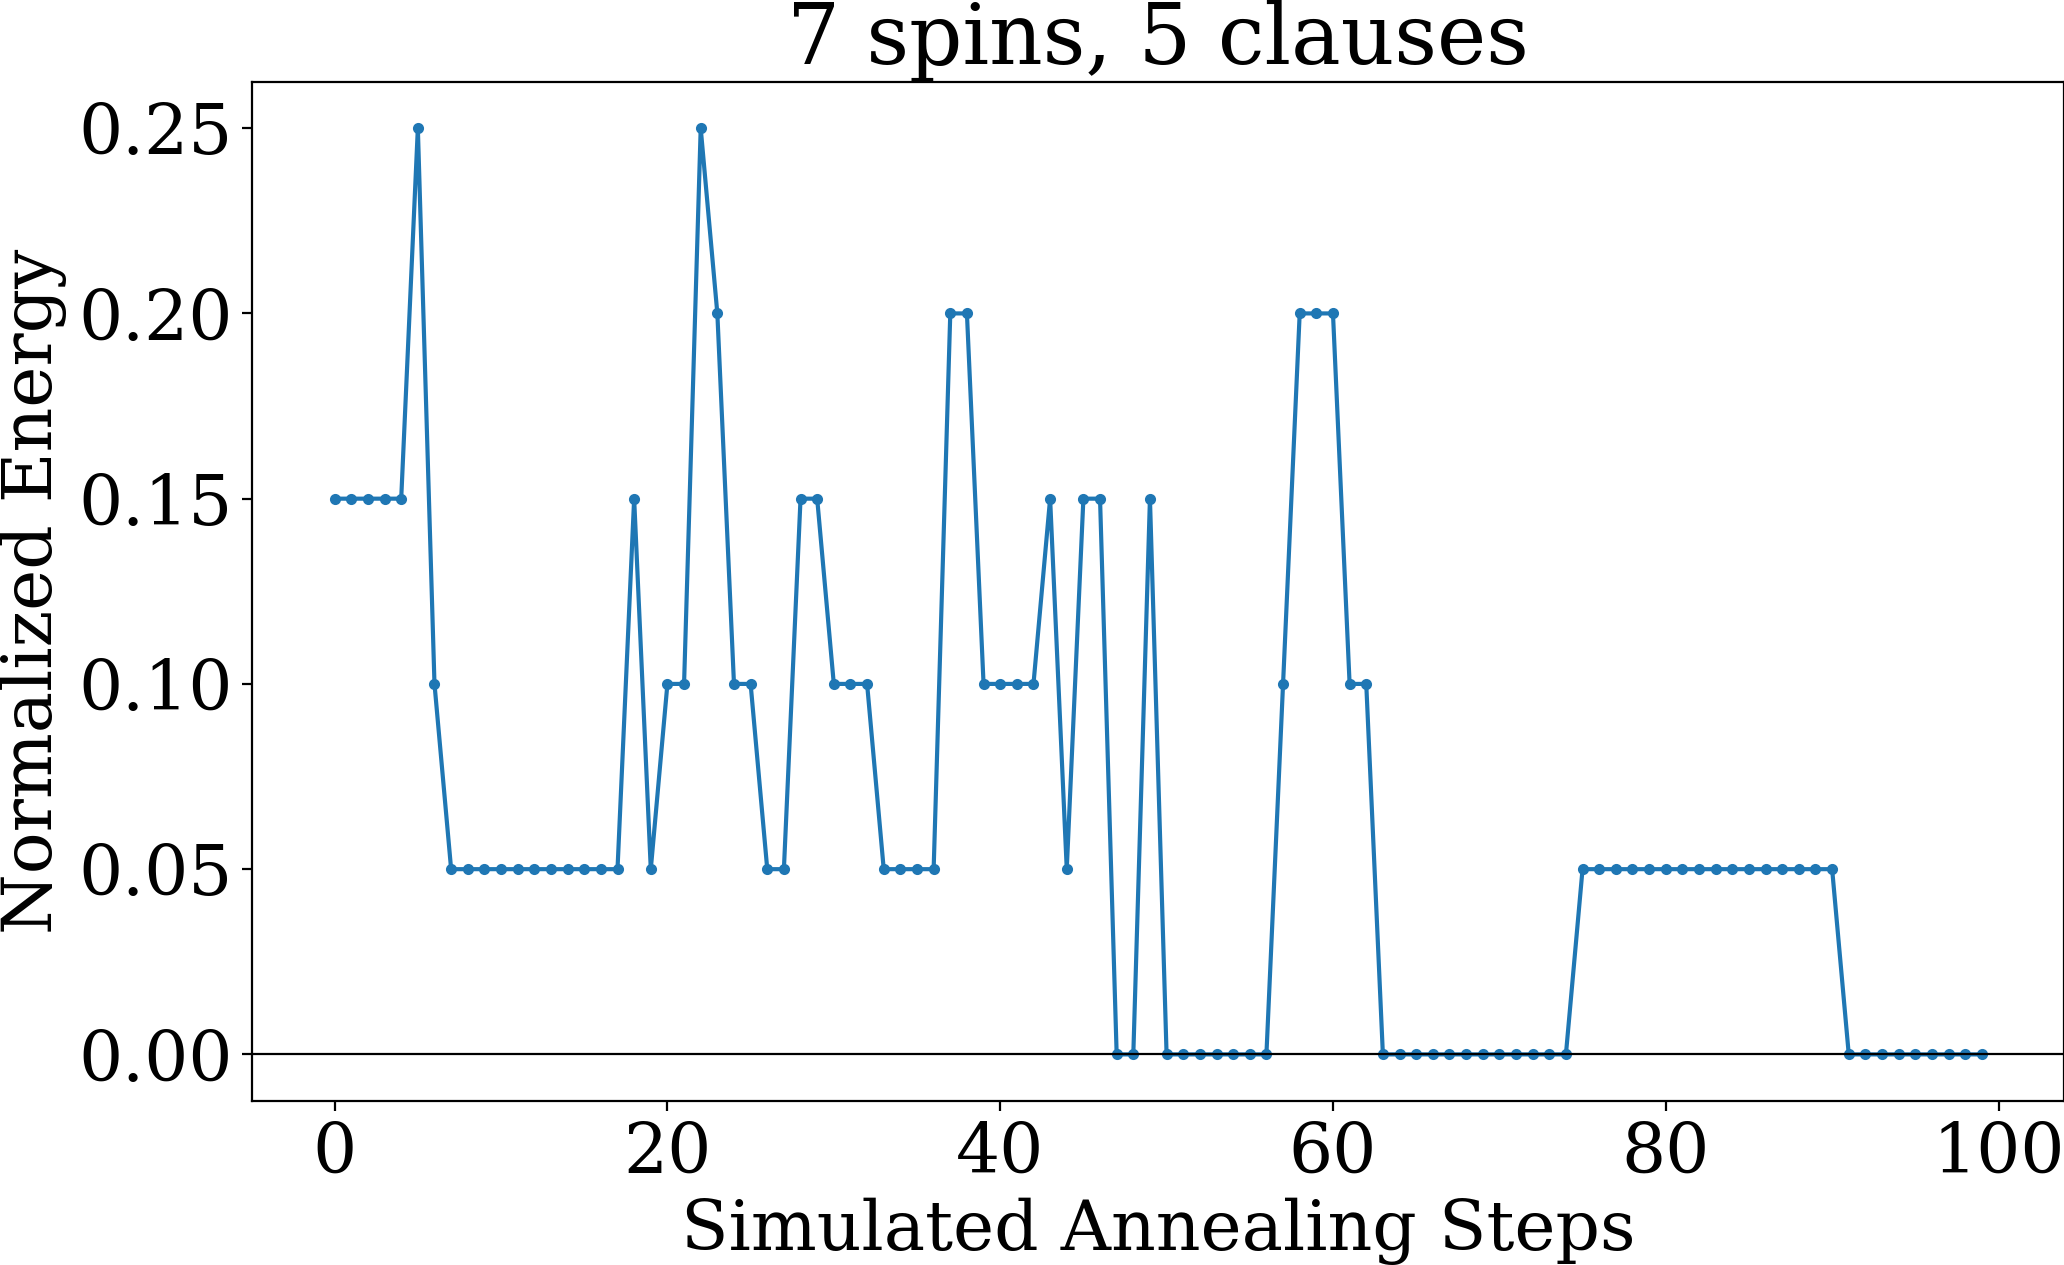

In [40]:
# plt.imshow(mc_time_states[...,0].T);
plt.imshow(
    np.concatenate((mc_time_states[..., 0].T,
                    (np.log1p(mc_time_energies[..., 0]) /
                     np.log1p(hamiltonian_diag_max) * 2 - 1).reshape(1, -1))))
plt.xlabel("Simulated Annealing Steps")
plt.ylabel("Spin Configuration")
plt.figure()
plt.plot(mc_time_energies[..., 0] / hamiltonian_diag_max, '.-')
plt.xlabel("Simulated Annealing Steps")
plt.ylabel("Normalized Energy")
# plt.yscale("symlog", linthreshy=8e-2)
plt.axhline(0, c='k', lw=0.8)
title = f"{num_spins} spins, {num_clauses} clauses"
plt.title(title);

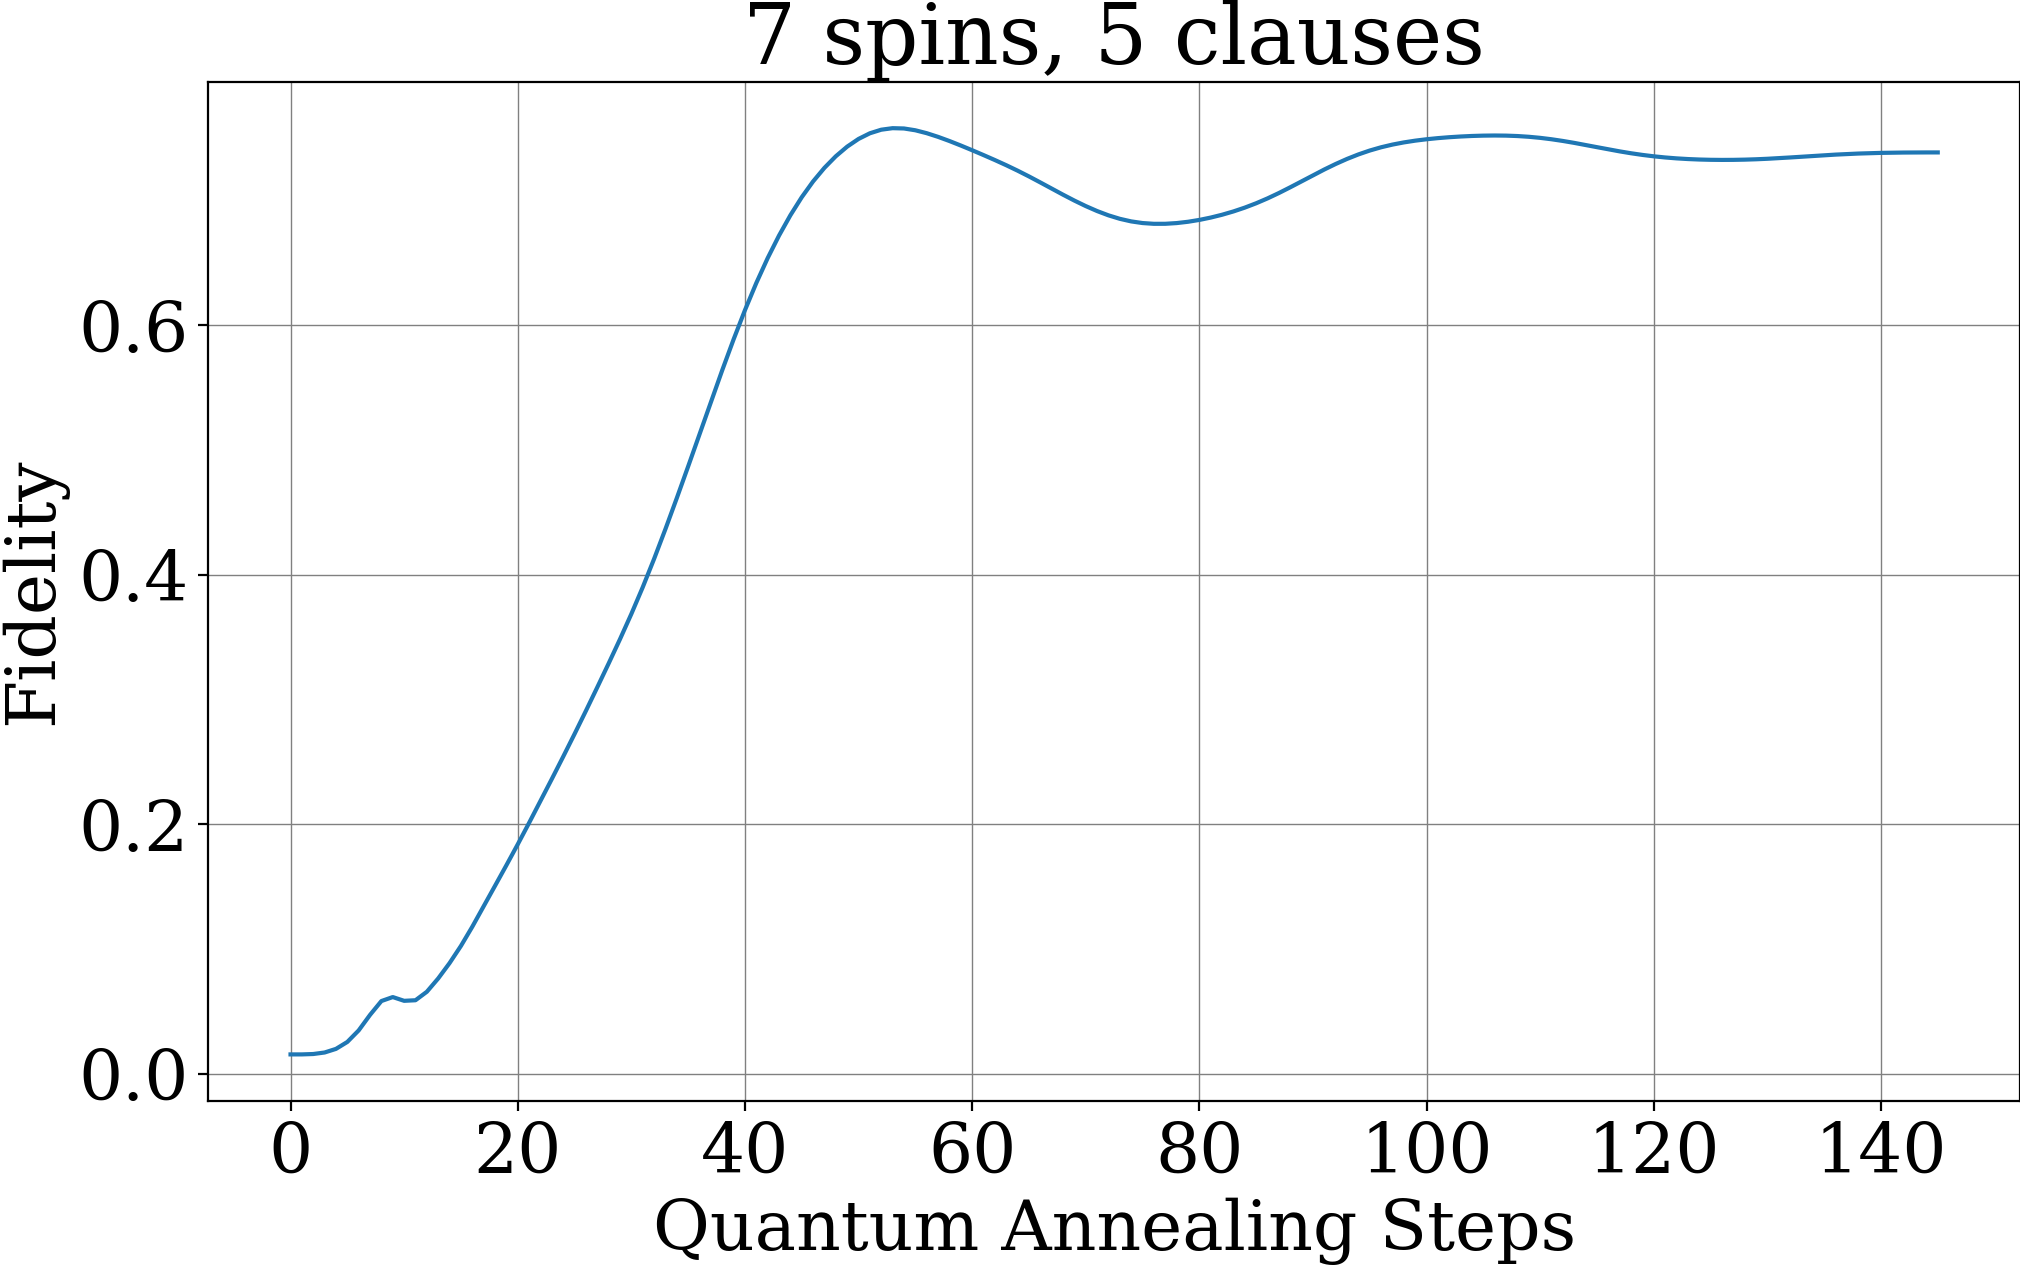

In [42]:
if isinstance(fidelity,list):
  for f in fidelity: plt.plot(f);
  fidelity, sol = fidelity[:3],fidelity[3:]
else:
  plt.plot(fidelity);
plt.ylabel("Fidelity"); plt.xlabel("Quantum Annealing Steps")
plt.grid(); plt.title(title);

# Data generation

In [46]:
def generate_data(num_spins_list, num_clauses_list, num_instances,
                 num_mc_steps, start_temperature, num_repetitions,
                 anneal_T, anneal_steps, folder_path):
    os.makedirs(folder_path,exist_ok=True)
    for num_spins in num_spins_list: # Number of spins loop
        miner = Miner(num_spins, folder_path)
        for num_clauses in num_clauses_list: # clauses loop

            # Create empty arrays
            res_clauses             = np.empty((num_instances,num_clauses,3,), dtype=np.uint8)
            res_hamiltonian_diag    = np.empty((num_instances,2**num_spins,), dtype=np.uint16)
            res_mc_timelines_energy = np.empty((num_instances,num_mc_steps,num_repetitions,), dtype=np.uint16)
            res_mc_timelines_state  = np.empty((num_instances,num_mc_steps, num_spins, num_repetitions,), dtype=np.int8)
            res_fidelity = [] #np.empty((num_instances,anneal_steps,))

            # make set of random clauses if they do not exist already and save them
            # clauses_name = f'EC3_N{num_spins}M{num_clauses}clauses.npz'
            clauses_name = f'EC3_N{num_spins}M{num_clauses}clauses_r.npz'
           
            if not os.path.isfile(folder_path + clauses_name):
                # clauses = make_set_random_clauses(num_instances, num_spins, num_clauses)
                clauses = np.empty((num_instances,num_clauses,3,), dtype=np.uint8)
                for i in range(num_instances):
                    miner.random_clauses(num_clauses)
                    clauses[i] = miner.clauses
                np.savez_compressed(folder_path + clauses_name,clauses=clauses,)
            # else: # TODO implement reuse of instances when generating more

            # generate all random ints at once
            res_rand_spins = np.random.randint(0, num_spins, size=(num_instances,num_repetitions,num_mc_steps), dtype=np.uint8)

            # solve each instance
            for idx_instance in trange(num_instances): # num_instances per clause loop
                # print(f'num_clauses {num_clauses}, idx_instance {idx_instance}',end='\r')

                # clauses, hamiltonian_diag, mc_timelines_energy, mc_timelines_state, fidelity = instance(miner,
                #     idx_instance, num_spins, num_clauses, res_rand_spins[idx_instance],
                #     num_mc_steps, start_temperature, num_repetitions, anneal_T, anneal_steps,)
                # clauses, hamiltonian_diag, mc_timelines_energy, mc_timelines_state, fid1, fid2 = instance(miner,
                #     idx_instance, num_spins, num_clauses, res_rand_spins[idx_instance],
                #     num_mc_steps, start_temperature, num_repetitions, anneal_T, anneal_steps,
                #     MC=True) # to compute only annealing, or both Q.annealing and SA
                # fidelity=[fid1,fid2]
                clauses, hamiltonian_diag, mc_timelines_energy, mc_timelines_state, fid2 = instance(miner,
                    idx_instance, num_spins, num_clauses, res_rand_spins[idx_instance],
                    num_mc_steps, start_temperature, num_repetitions, anneal_T, anneal_steps,
                    MC=True) # to compute only annealing, or both Q.annealing and SA
                fidelity= fid2
                res_clauses[idx_instance] = clauses
                res_hamiltonian_diag[idx_instance] = hamiltonian_diag
                res_mc_timelines_energy[idx_instance] = mc_timelines_energy
                res_mc_timelines_state[idx_instance] = mc_timelines_state
                res_fidelity.append(fidelity)

            # save data #######################################################
            # file number to avoid overwriting
            # folder_path = 'data/raw/mc_clauses_with_unique_GS/'
            fnum = 0
            while True:
                file_name = f'EC3_N{num_spins}M{num_clauses}' + \
                    f'_T{start_temperature}_mc{num_mc_steps}r{num_repetitions}_{fnum}'
                if not os.path.isfile(folder_path + file_name + '.npz'):
                    break
                else:
                    fnum += 1

            # fidelities with different number of QA steps
            res_fidelity = np.array(res_fidelity, dtype=object)
            # Save data file
            np.savez_compressed(folder_path + f'{file_name}.npz',
                     res_clauses=res_clauses,
                     res_rand_spins=res_rand_spins,
                     res_hamiltonian_diag=res_hamiltonian_diag,
                     res_mc_timelines_energy=res_mc_timelines_energy,
                     res_mc_timelines_state=res_mc_timelines_state,
                     res_fidelity=res_fidelity)

            # Save text file for parameters
            with open(folder_path + f'{file_name}.txt', 'w') as f:
                print(f'num_spins = {num_spins} \n' +
                      f'num_clauses = {num_clauses} \n' +
                      f'num_instances = {num_instances} \n' +
                      f'num_mc_steps = {num_mc_steps} \n' +
                      f'start_temperature = {start_temperature} \n' +
                      f'num_repetitions = {num_repetitions} \n' +
                      f'anneal_T = {anneal_T} \n' + f'anneal_steps = {anneal_steps}',
                      file=f)
        # end clauses loop

In [49]:
data_args = dict(num_spins_list =  [12],
                 num_clauses_list = [10,15,20,25],
                 num_instances = 10_000, # solving trials per clause
                 start_temperature = 10,
                 num_mc_steps = 100,
                 num_repetitions = 10, # for the same instance, different initial states of MC
                 anneal_T = 10,
                 anneal_steps = 500,
                 folder_path = 'data/raw/mc_clauses_with_unique_GS/', # mc_clauses_with_degenerate_GS
                )

In [ ]:
generate_data(**data_args)

## Load and check

In [53]:
# Perform a test for four clauses and two instances
res = np.load(data_args['folder_path']+'EC3_N12M10_T10_mc100r10_0.npz', allow_pickle=True)

In [54]:
res.files

['res_clauses',
 'res_rand_spins',
 'res_hamiltonian_diag',
 'res_mc_timelines_energy',
 'res_mc_timelines_state',
 'res_fidelity']

In [55]:
res['res_clauses'].shape, res['res_hamiltonian_diag'].shape, res['res_mc_timelines_energy'].shape, res['res_mc_timelines_state'].shape

((10, 10, 3), (10, 4096), (10, 100, 10), (10, 100, 12, 10))

In [57]:
res_f = res['res_fidelity']
res_f.shape, res_f[7].shape, res_f[3].shape

((10,), (182,), (147,))

In [58]:
res['res_clauses'][0]

array([[ 5,  8,  9],
       [ 3,  8, 10],
       [ 0,  8, 10],
       [ 2,  9, 11],
       [ 0,  5,  6],
       [ 7,  8, 10],
       [ 3,  5,  8],
       [ 2,  5, 10],
       [ 2,  3,  4],
       [ 0,  1,  8]], dtype=uint8)

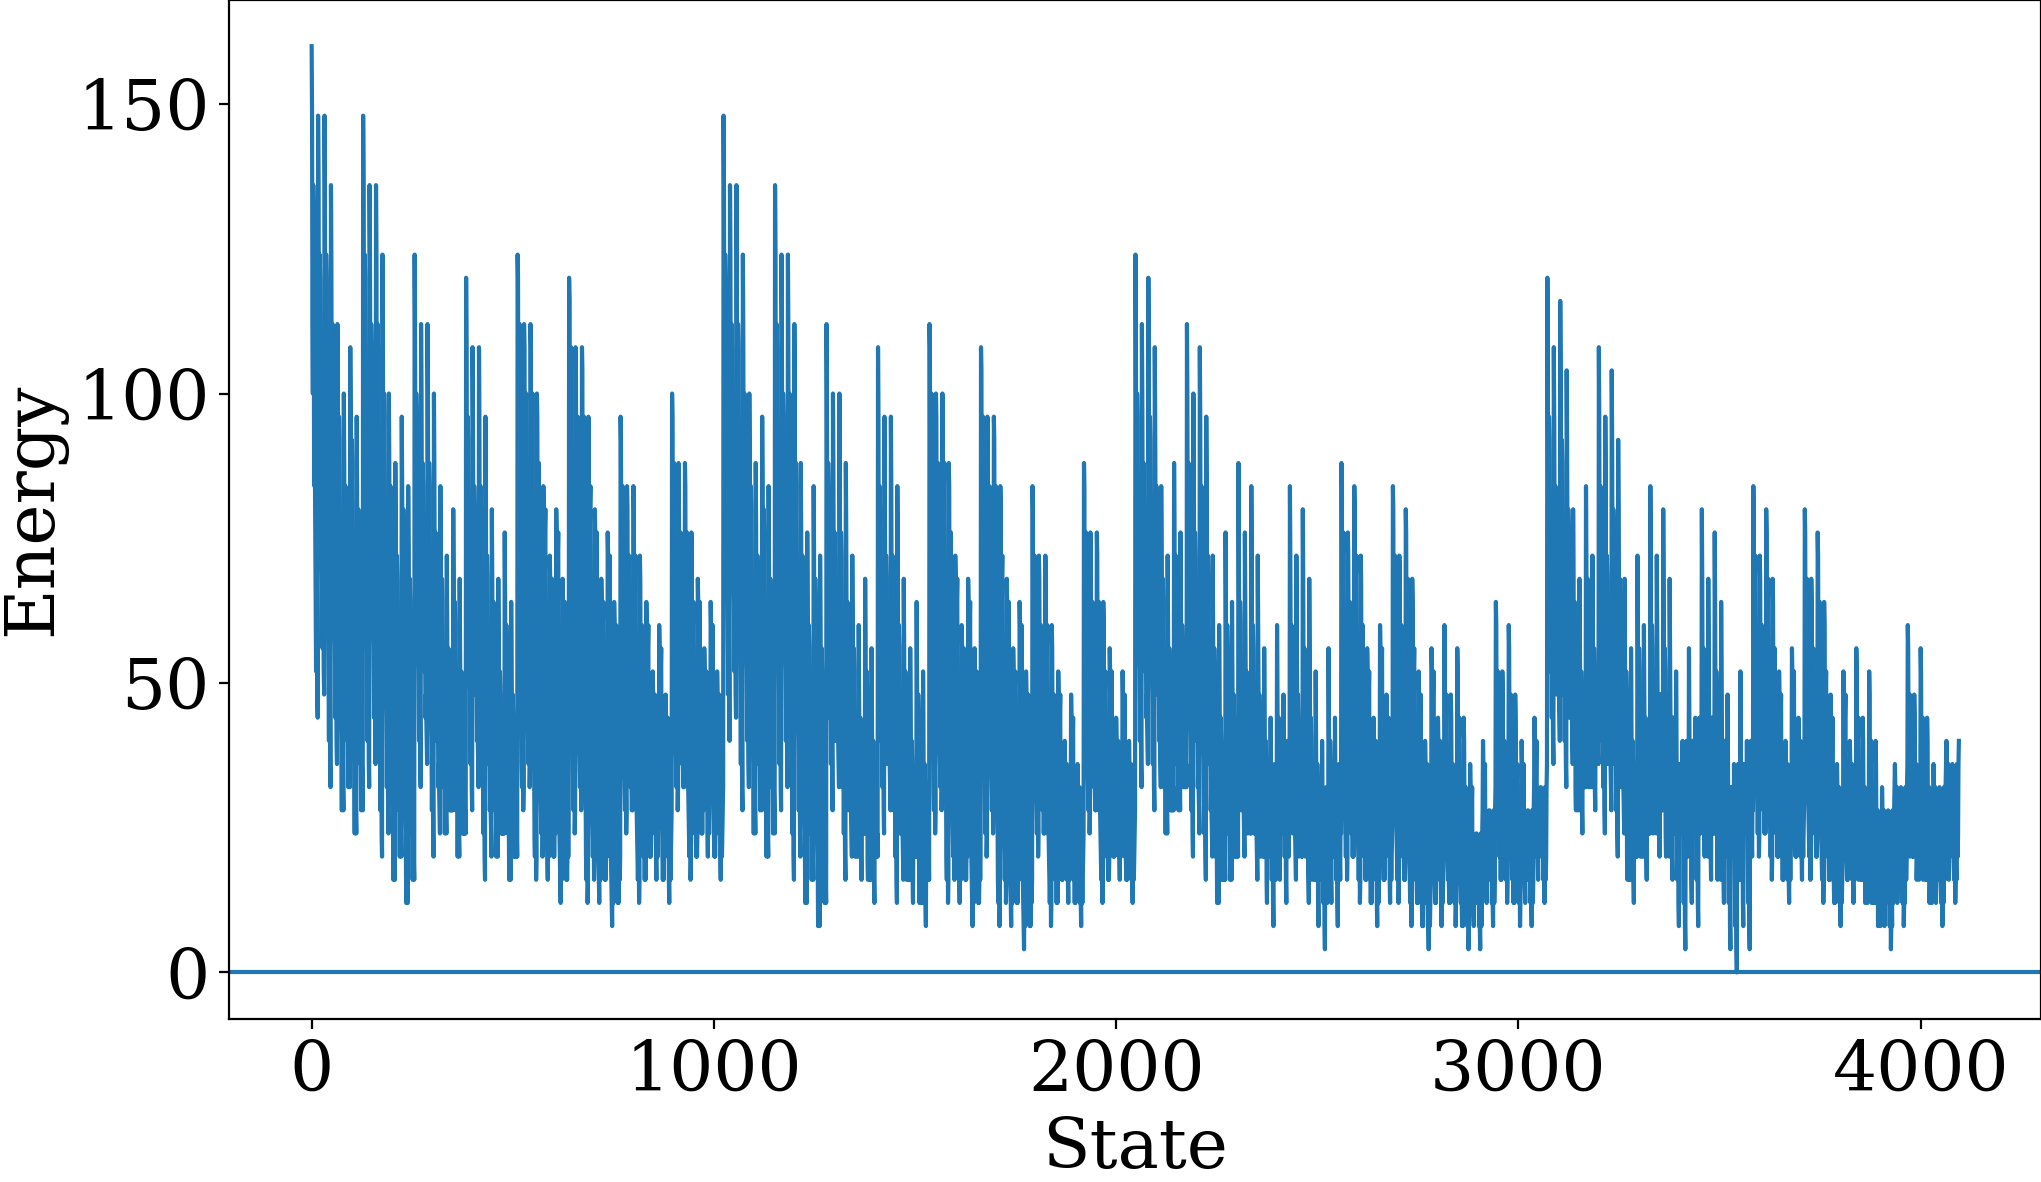

In [59]:
plt.plot(res['res_hamiltonian_diag'][0]);
plt.axhline(0);
plt.xlabel('State')
plt.ylabel('Energy');

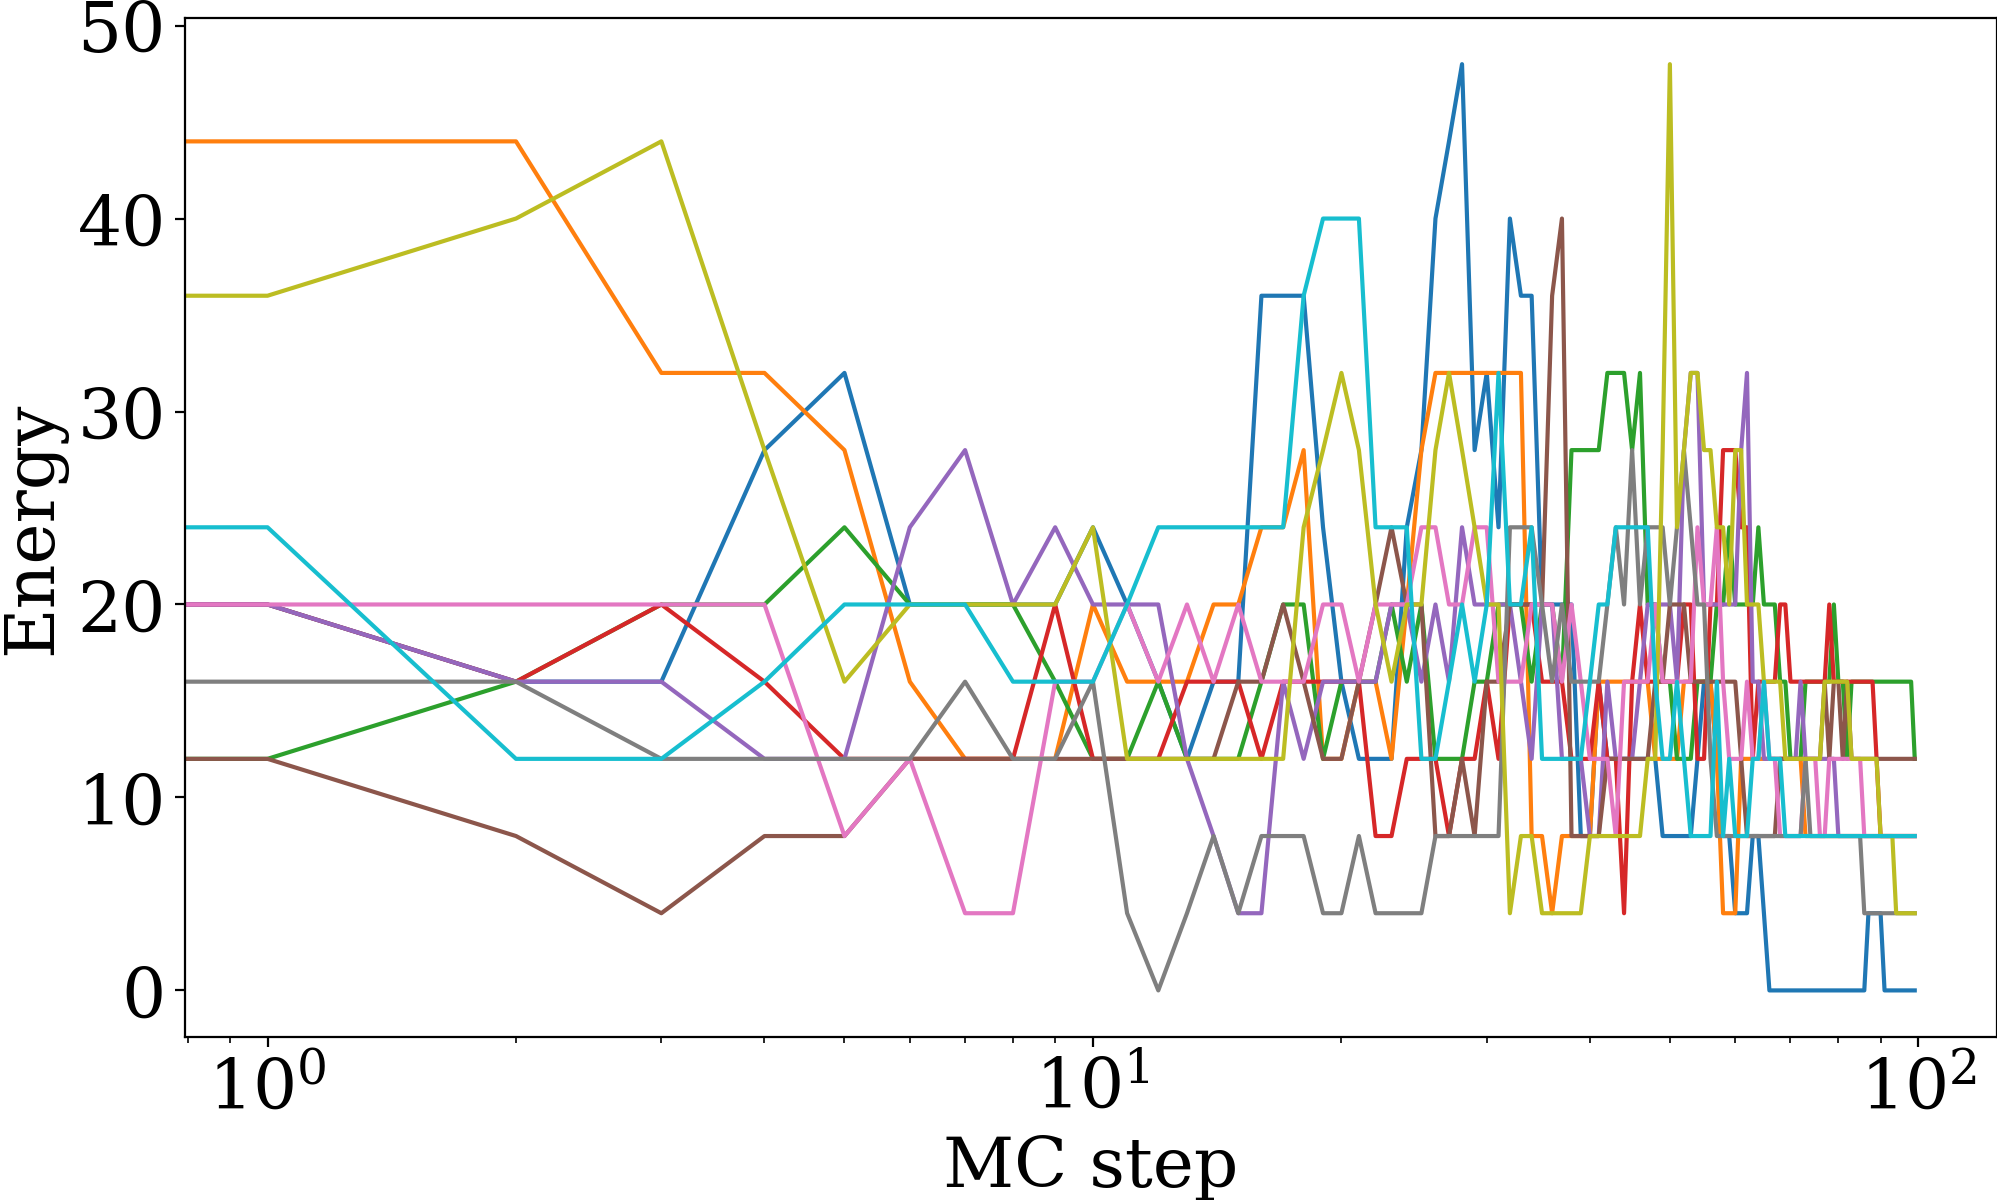

In [61]:
plt.semilogx(res['res_mc_timelines_energy'][0]);
plt.xlabel('MC step'); plt.ylabel('Energy');

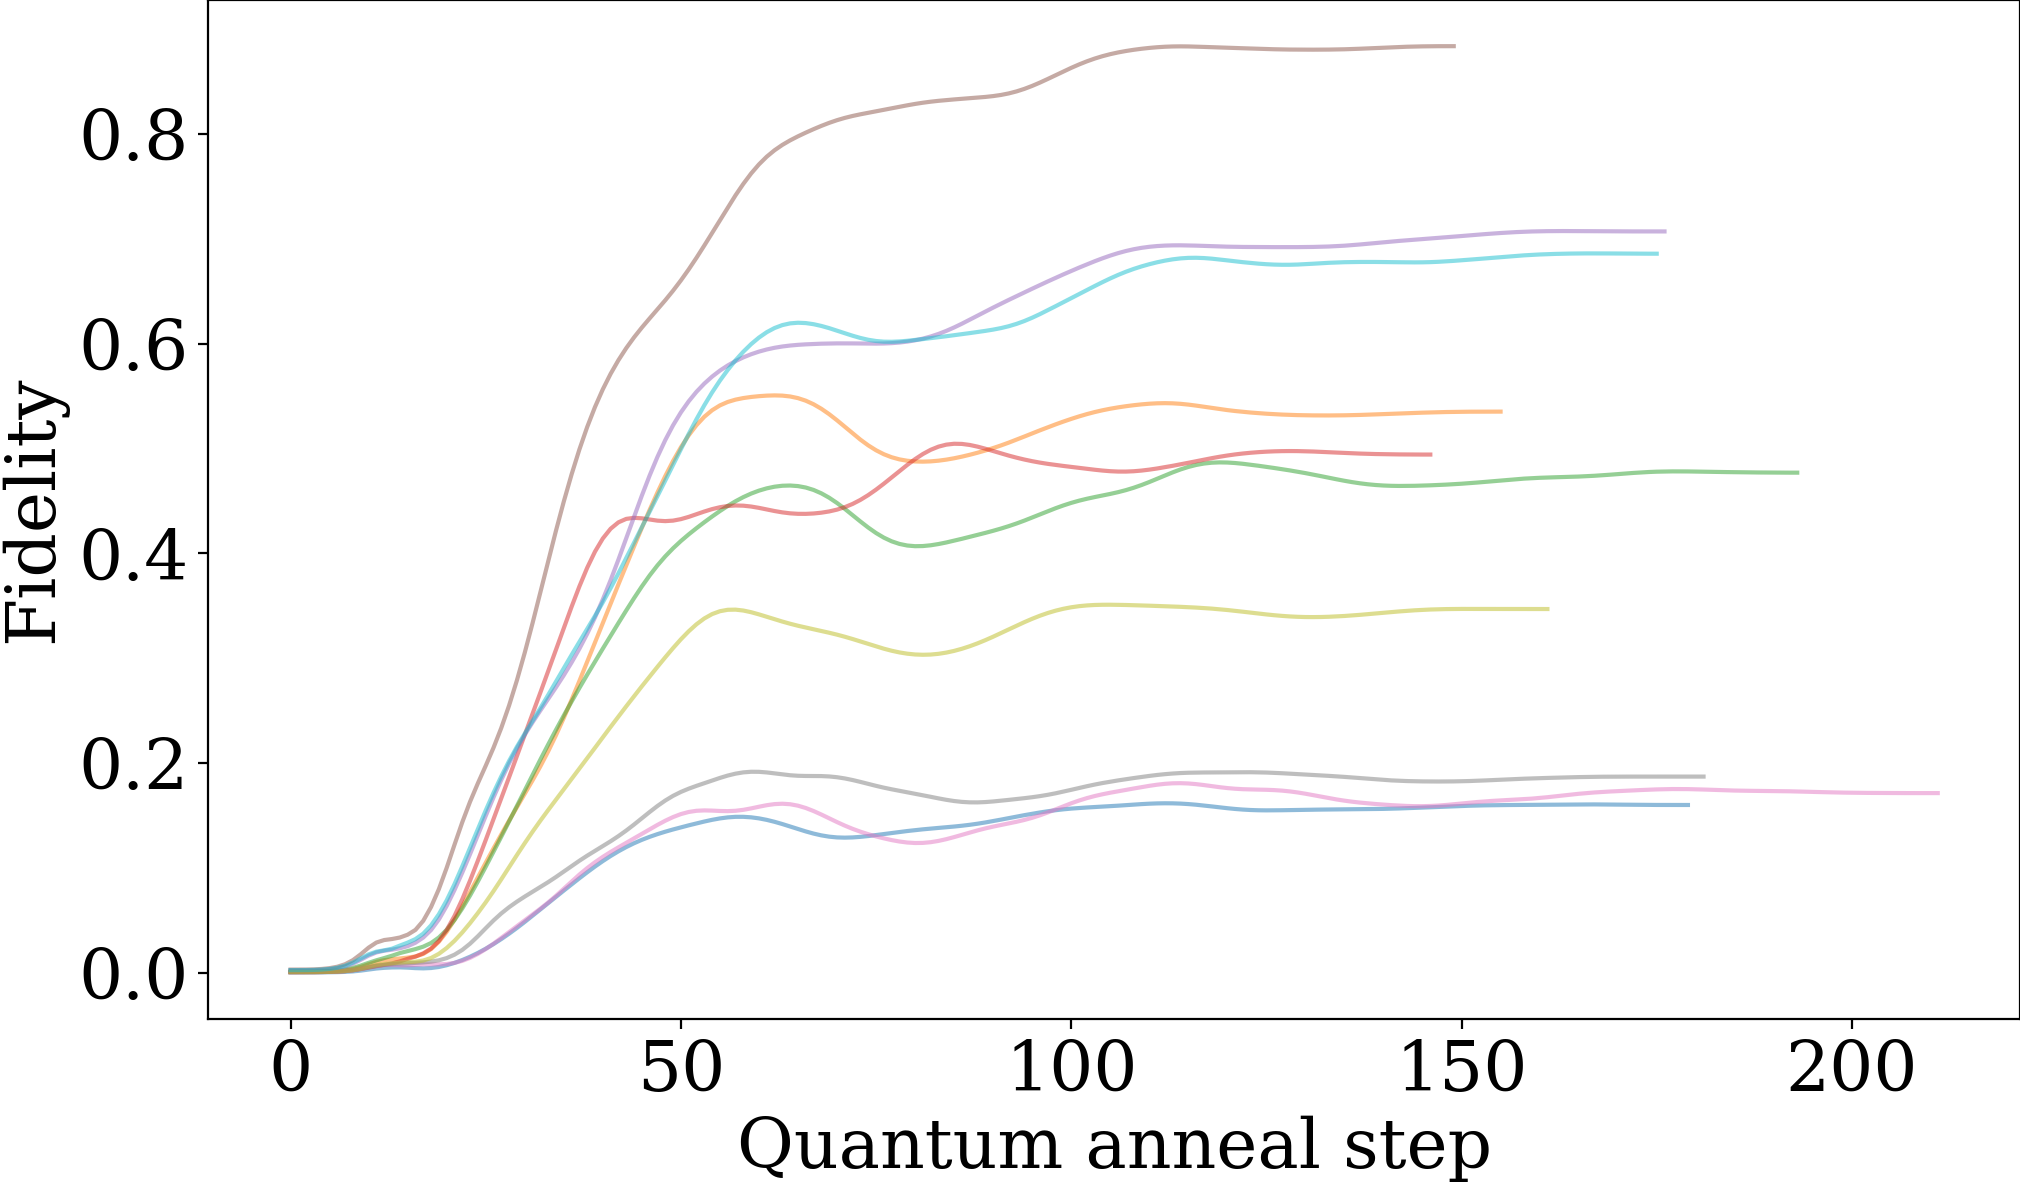

In [66]:
for i in range(min(len(res['res_fidelity']),1000)):
    plt.plot(res['res_fidelity'][i], alpha=0.5);
plt.xlabel('Quantum anneal step'); plt.ylabel('Fidelity');